# **의사결정트리와 앙상블 모델**

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

plt.rc('font', family='NanumBarunGothic')
get_ipython().run_line_magic('matplotlib', 'inline')

from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, plot_roc_curve, plot_confusion_matrix, classification_report

from sklearn.pipeline import Pipeline, make_pipeline
from joblib import dump, load

# <font color='blue'> **가. 의사결정 트리**
## **1. 의사결정 트리 (CHAID, C4.5, C5.0, CART) 특성**
- 쉽다
- 스무고개 질문방식 (Split & Pruning)
- 유연하다(수치형/범주형을 모두 다룬다)
- 실용적이다(데이터전처리를 대충한다. No 표준화, No 결측치 처리)
- 관측된 자료에서 예측 확률을 계산하는 비모수통계(Non parametric) 알고리즘

## **2. 의사결정 트리 정적/동적 구조**
#### **Static**
- Original Node, Node
- Depth
- Leaf

### **Dynamic**
#### Split & pruning 방식
- 스무고개 질문을 끝까지 하면(A greedy approach to create a binary decision tree) 정답을 맞춘다
     * **Recursive Binary Splitting.** (like KD tree algorithm) 
- 수치해석(Numerical procedure)측면에서는 모든 인스턴스는 다양한 질문(different split points)으로 시험하고 손실함수(Shannon information, **Entrophy)가 가장 적은 Split을 optimization** 하여 나무를 만들어 간다.

DecisionTreeClassifier(random_state=11)

<Figure size 1800x576 with 0 Axes>

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
No handles with labels found to put in legend.


findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


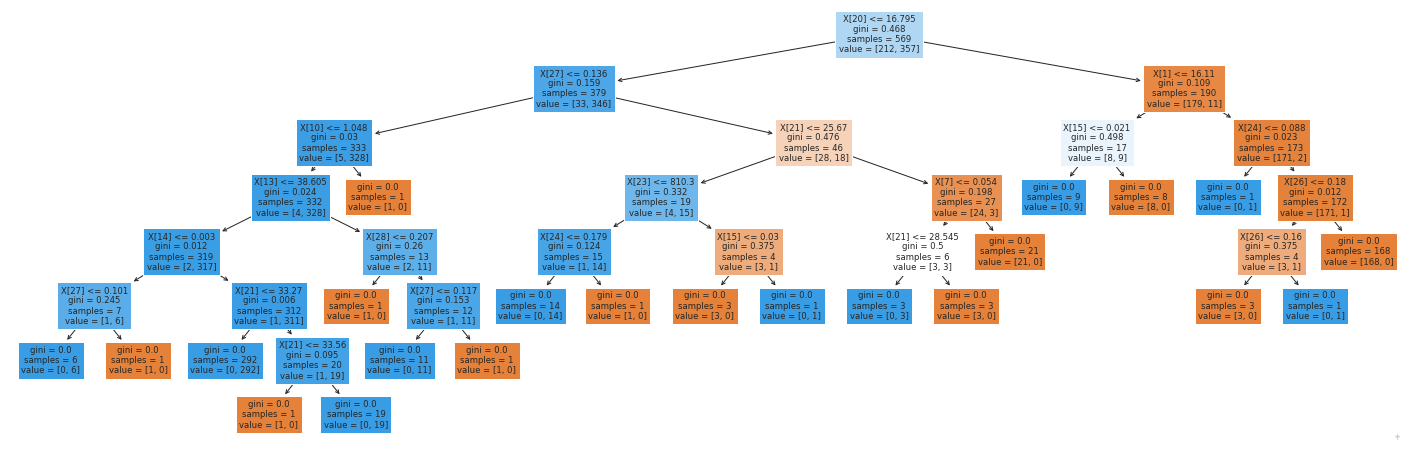

In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier, plot_tree
data = load_breast_cancer()

X = pd.DataFrame(data.data, columns= data.feature_names)
y = pd.Series(data.target)
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, 
                                                  stratify= y, random_state=11)
dt = DecisionTreeClassifier(random_state=11)
dt.fit(X, y)

plt.figure(figsize=(25,8))
ax = plot_tree(dt, filled=True)
plt.legend(loc='lower right', borderpad=0, handletextpad=0)

- 모델의 특성상 자료의 레이블이 완전히 분류될 때까지 ‘leaf’의 개수를 최대화하여 훈련하게 되어 **과적합이 발생하기 쉬움**
- 사이킷런은 과적합이 발생하기 전에 훈련을 일찍 종료시키기 위해 ‘**depth’의 크기, ‘leaf’의 최대 개수, ‘노드의 sample 개수 등의 하이퍼파라미터**를 적용하여 과적합을 방지
- 하이퍼파라미터를 적용하여 나무를 가지치기(pruning)하는 것은 과적합을 방지하기 위해 **패널티 방식(Regularization)**

<img src='https://images.velog.io/images/arittung/post/b6b0af1e-7d85-418a-8097-b97c0b5d15b6/image.png'>

## **3. Pruning 기준(Entropy가 낮은 수준으로)**
- Shannon의 Information
    * 추상적 개념인 모든 정보는 bits로 계량화 (모든 물질은 원자로 나누어진다)
    * 정보(Information)라고 하는 것은 'Surprise'의 역수
    * 어떤 사실이 나타날 확률(p(x))이 높을수록 새로운 것(Information)이 없음

<img src='https://media.istockphoto.com/photos/atom-picture-id1177065271?b=1&k=20&m=1177065271&s=170667a&w=0&h=SHqlFfkHrOsGbUn1IyjvYmVAAfBijRKoL4T9-F2psu4=' width =500>

## **${I(x)}$ = $\frac{1}{p(x)}$**

<img src ='https://miro.medium.com/max/1313/1*l0AqopDa5_h7KaOMB-Um3Q.jpeg' width=300>

- https://medium.com/udacity/shannon-entropy-information-gain-and-picking-balls-from-buckets-5810d35d54b4

## **4. 의사결정 tree의 Loss function 종류**

In [ ]:
def gini(p):
   return (p)*(1 - (p)) + (1 - p)*(1 - (1-p))
def cross_entropy(p):
   return - p*np.log2(p) - (1 - p)*np.log2((1 - p))

<Figure size 864x360 with 0 Axes>

(0.0, 1.1)

Text(0.5, 0, 'p(i=1)')

Text(0, 0.5, 'The Impurity of Information ')

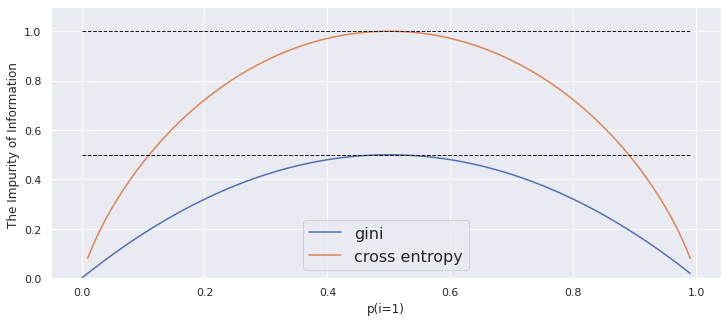

In [ ]:
plt.figure(figsize=(12, 5)); plt.rc('legend', fontsize=16)
x = np.arange(0.0, 1, 0.01)
plt.plot(x, gini(x), label='gini'); plt.legend() # pq*2(이진분류)
plt.plot(x, [cross_entropy(p) if p != 0 else None for p in x],  label='cross entropy')

plt.legend()
plt.plot(x, [0.5]*x.shape[0], linewidth=1, color='k', linestyle='--')
plt.plot(x, [1.0]*x.shape[0], linewidth=1, color='k', linestyle='--')
plt.ylim([0, 1.1]); plt.xlabel('p(i=1)'); plt.ylabel('The Impurity of Information ')

<img src='https://miro.medium.com/max/1400/0*kvGUcLiyuVud7q6N.' width=500>

## **5. 특성변수 model-based 중요도**
- 랜덤포레스트 모델의 입력변수의 중요도(Impurity 기준)를 X축으로 하여 변수명을 시각화

In [ ]:
dt.get_params()
print('\n')
dt.feature_importances_

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 11,
 'splitter': 'best'}

array([0.        , 0.03120753, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00877112, 0.        , 0.        ,
       0.007316  , 0.        , 0.        , 0.00204521, 0.00100384,
       0.03747995, 0.        , 0.        , 0.        , 0.        ,
       0.69559352, 0.05735376, 0.        , 0.0110859 , 0.01440488,
       0.        , 0.00747439, 0.12043256, 0.00583135, 0.        ])

<BarContainer object of 30 artists>

[Text(0, 0, 'mean radius'),
 Text(0, 0, 'mean texture'),
 Text(0, 0, 'mean perimeter'),
 Text(0, 0, 'mean area'),
 Text(0, 0, 'mean smoothness'),
 Text(0, 0, 'mean compactness'),
 Text(0, 0, 'mean concavity'),
 Text(0, 0, 'mean concave points'),
 Text(0, 0, 'mean symmetry'),
 Text(0, 0, 'mean fractal dimension'),
 Text(0, 0, 'radius error'),
 Text(0, 0, 'texture error'),
 Text(0, 0, 'perimeter error'),
 Text(0, 0, 'area error'),
 Text(0, 0, 'smoothness error'),
 Text(0, 0, 'compactness error'),
 Text(0, 0, 'concavity error'),
 Text(0, 0, 'concave points error'),
 Text(0, 0, 'symmetry error'),
 Text(0, 0, 'fractal dimension error'),
 Text(0, 0, 'worst radius'),
 Text(0, 0, 'worst texture'),
 Text(0, 0, 'worst perimeter'),
 Text(0, 0, 'worst area'),
 Text(0, 0, 'worst smoothness'),
 Text(0, 0, 'worst compactness'),
 Text(0, 0, 'worst concavity'),
 Text(0, 0, 'worst concave points'),
 Text(0, 0, 'worst symmetry'),
 Text(0, 0, 'worst fractal dimension')]

Text(0, 0.5, 'Features Importance')

Text(0.5, 1.0, 'feature_importances')

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


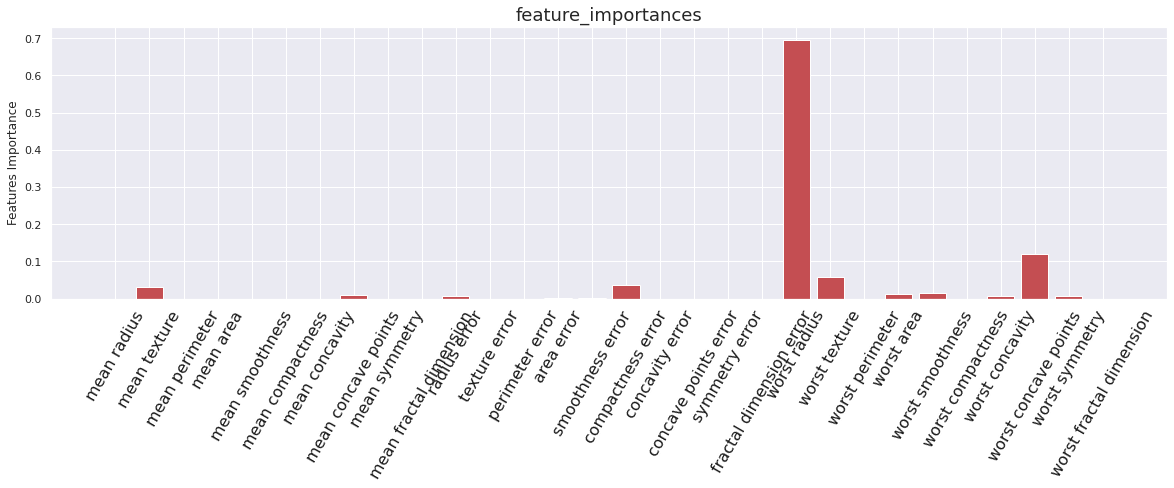

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
ax.bar(range(X.shape[1]), dt.feature_importances_, color='r')
ax.set_xticks(np.arange(X.shape[1]))
ax.set_xticklabels(X.columns, rotation='60', color="k", size=16)
ax.set_ylabel('Features Importance')
ax.set_title('feature_importances', fontsize=18)

- Model interpretability_2. 특성변수 permutation-based 중요도
     * 특정 변수의 값을 무작위로 재정렬하여(permutation) 학습하는 경우 모델의 정확도에 영향을 얼마나 주는지를 가리키는 지표
     * model_based’ 중요도의 크기와는 다르다. 사이킷런의 Permutation-based feature importance모듈을 호출
     * 예측에 영향을 미치는 입력변수의 중요도가 높은 순서대로 확인

In [ ]:
X_test.head()
X_test.iloc[:,0:4].apply(np.random.permutation).head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
186,18.310,18.58,118.60,1041.0,0.08588,0.08468,0.08169,0.05814,0.1621,0.05425,...,21.31,26.36,139.20,1410.0,0.12340,0.24450,0.35380,0.15710,0.3206,0.06938
409,12.270,17.92,78.41,466.1,0.08685,0.06526,0.03211,0.02653,0.1966,0.05597,...,14.10,28.88,89.00,610.2,0.12400,0.17950,0.13770,0.09532,0.3455,0.06896
470,9.667,18.49,61.49,289.1,0.08946,0.06258,0.02948,0.01514,0.2238,0.06413,...,11.14,25.62,70.88,385.2,0.12340,0.15420,0.12770,0.06560,0.3174,0.08524
543,13.210,28.06,84.88,538.4,0.08671,0.06877,0.02987,0.03275,0.1628,0.05781,...,14.37,37.17,92.48,629.6,0.10720,0.13810,0.10620,0.07958,0.2473,0.06443
37,13.030,18.42,82.61,523.8,0.08983,0.03766,0.02562,0.02923,0.1467,0.05863,...,13.30,22.81,84.46,545.9,0.09701,0.04619,0.04833,0.05013,0.1987,0.06169


,mean radius,mean texture,mean perimeter,mean area
186,10.51,13.21,82.71,1230.0
409,10.17,15.45,70.39,551.1
470,18.63,21.53,137.80,678.1
543,14.62,22.47,91.38,338.3
37,11.87,23.93,97.41,793.2


**Permutation**
<img src='https://blog.socratesk.com/assets/img/rand_shuffle.png'>

<Figure size 1440x360 with 0 Axes>

Text(0, 0.5, 'Features Permutation Importance')

Text(0.5, 1.0, 'Features Permutation Importance')

([<matplotlib.axis.XTick at 0x7f39189f7710>,
 [Text(0, 0, 'mean radius'),
  Text(0, 0, 'mean texture'),
  Text(0, 0, 'mean perimeter'),
  Text(0, 0, 'mean area'),
  Text(0, 0, 'mean smoothness'),
  Text(0, 0, 'mean compactness'),
  Text(0, 0, 'mean concavity'),
  Text(0, 0, 'mean concave points'),
  Text(0, 0, 'mean symmetry'),
  Text(0, 0, 'mean fractal dimension'),
  Text(0, 0, 'radius error'),
  Text(0, 0, 'texture error'),
  Text(0, 0, 'perimeter error'),
  Text(0, 0, 'area error'),
  Text(0, 0, 'smoothness error'),
  Text(0, 0, 'compactness error'),
  Text(0, 0, 'concavity error'),
  Text(0, 0, 'concave points error'),
  Text(0, 0, 'symmetry error'),
  Text(0, 0, 'fractal dimension error'),
  Text(0, 0, 'worst radius'),
  Text(0, 0, 'worst texture'),
  Text(0, 0, 'worst perimeter'),
  Text(0, 0, 'worst area'),
  Text(0, 0, 'worst smoothness'),
  Text(0, 0, 'worst compactness'),
  Text(0, 0, 'worst concavity'),
  Text(0, 0, 'worst concave points'),
  Text(0, 0, 'worst symmetry'),
 

<BarContainer object of 30 artists>

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


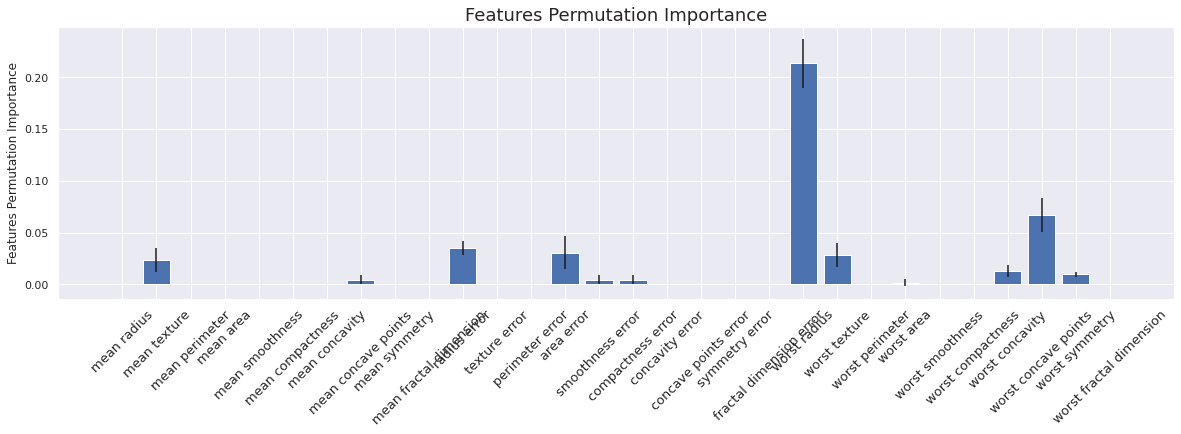

In [ ]:
from sklearn.inspection import permutation_importance
result = permutation_importance(dt, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
feature_names = [f'feature {i}' for i in range(X.shape[1])]
forest_importances = pd.Series(result.importances_mean, index=feature_names)

plt.figure(figsize=(20,5)); plt.ylabel('Features Permutation Importance')
plt.title('Features Permutation Importance', fontsize=18)
plt.xticks(np.arange(X.shape[1]), X.columns, rotation='45', fontsize=13)
plt.bar(range(X.shape[1]), forest_importances, yerr=result.importances_std, color='b')

## **6. Hyperparametr Tunining**
- 의사결정 나무의 Hyperparameters 설명
     * criterion : 노드의 가지치기에 적용되는 기준으로 ‘gini’, ‘entropy’에서 선택
     * splitter : 가지치기에 ‘criterion’ 혹은 무작위(random) 기준 파라미터로 extra tree()알고리즘은 무작위로 설정
     * max_depth : 의사결정트리의 크기로 전체 노드의 계층의 크기
     * min_samples_split : 가지치기를 할 노드의 최소 데이터 수, 수치가 작을수록 자료를 자세히 학습하여 과적합 발생
     * min_samples_leaf : 최종 노드인 ‘leaf’의 최소 데이터 수, 불균형 자료에서는 일반적으로 낮은 값을 설정하여 소수 범주의 유형을 분류하여 예측 성능을 상승
     * min_weight_fraction_leaf : 최종 노드인 ‘leaf’의 데이터 비율로 min_samples_leaf와 같은 기능
     * max_leaf_nodes : ‘leaf’의 개수로 ‘max_depth’과 같은 기능
     * max_features : 가지치기에서 반영될 특성 변수의 개수로, 총 특성변수의 개수의 제곱근을 일반적으로 사용하며 높을수록 과적합 발생
     * class_weight : 소수와 다수 범주 자료의 유형 비중에 대한 가중치 파라미터

In [ ]:
params = {
    'criterion' :['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth' : np.arange(1,15),
    'min_samples_split': np.arange(0.005, 0.1, 0.001),
    'min_samples_leaf': [0.005, 0.01, 0.05, 0.10], # np.arange(0.005, 0.1, 0.001)
    'max_features': ['auto', 'sqrt', 'log2'],
}

np.random.seed(1111)
kf = KFold(n_splits=2)
model = DecisionTreeClassifier(random_state=11)
grid = RandomizedSearchCV(model, params, cv=kf, n_iter=50, 
                          scoring = 'recall_macro', verbose =True)
grid.fit(X_train, y_train)
print(f'optimal parameter: {grid.best_params_}')

Fitting 2 folds for each of 50 candidates, totalling 100 fits


RandomizedSearchCV(cv=KFold(n_splits=2, random_state=None, shuffle=False),
                   estimator=DecisionTreeClassifier(random_state=11), n_iter=50,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [0.005, 0.01, 0.05,
                                                             0.1],
                                        'min_samples_split': array([0.005,...
       0.05 , 0.051, 0.052, 0.053, 0.054, 0.055, 0.056, 0.057, 0.058,
       0.059, 0.06 , 0.061, 0.062, 0.063, 0.064, 0.065, 0.066, 0.067,
       0.068, 0.069, 0.07 , 0.071, 0.072, 0.073, 0.074, 0.075, 0.076,
       0.077, 0.078, 0.079, 0.08 , 0.081, 0.082, 0.083, 0.084, 0.085,
       0

optimal parameter: {'splitter': 'best', 'min_samples_split': 0.01, 'min_samples_leaf': 0.01, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'entropy'}


In [ ]:
print('optimal parameter: {}'.format(grid.best_params_))

optimal parameter: {'splitter': 'best', 'min_samples_split': 0.01, 'min_samples_leaf': 0.01, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'entropy'}


- 사용자 정의함수의 일반 인자(*arg)와 키워드 인자(**kwarg)를 사용
    * 사용자정의함수 괄호 안의 인자는 사전에 인자를 정하지 않는 경우
    * 일반 인자(*arg)와 달리 키워드 인자(**kwarg)는 파이썬의 사전(dictionary)자료 형태인 key와 value를 아는 경우이다

In [ ]:
def catch_all(*args, **kwargs):
    print("args =", args)
    print("kwargs =", kwargs)

catch_all(1, 2, 3, 4, a=7, b=5)

args = (1, 2, 3, 4)
kwargs = {'a': 7, 'b': 5}


In [ ]:
catch_all('a',keyword=2)

args = ('a',)
kwargs = {'keyword': 2}


In [ ]:
catch_all(**{'keyword': 3, 'name': 'ancestor9'})

args = ()
kwargs = {'keyword': 3, 'name': 'ancestor9'}


best parameters를 모델의 인자로 받아 특성변수의 중요도를 시각화

In [ ]:
model.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 11,
 'splitter': 'best'}

In [ ]:
best_params = grid.best_params_
tuned_params = {item[:]: best_params[item] for item in best_params}
tuned_params

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 0.01,
 'min_samples_split': 0.01,
 'splitter': 'best'}

DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features='sqrt',
                       min_samples_leaf=0.01, min_samples_split=0.01,
                       random_state=11)

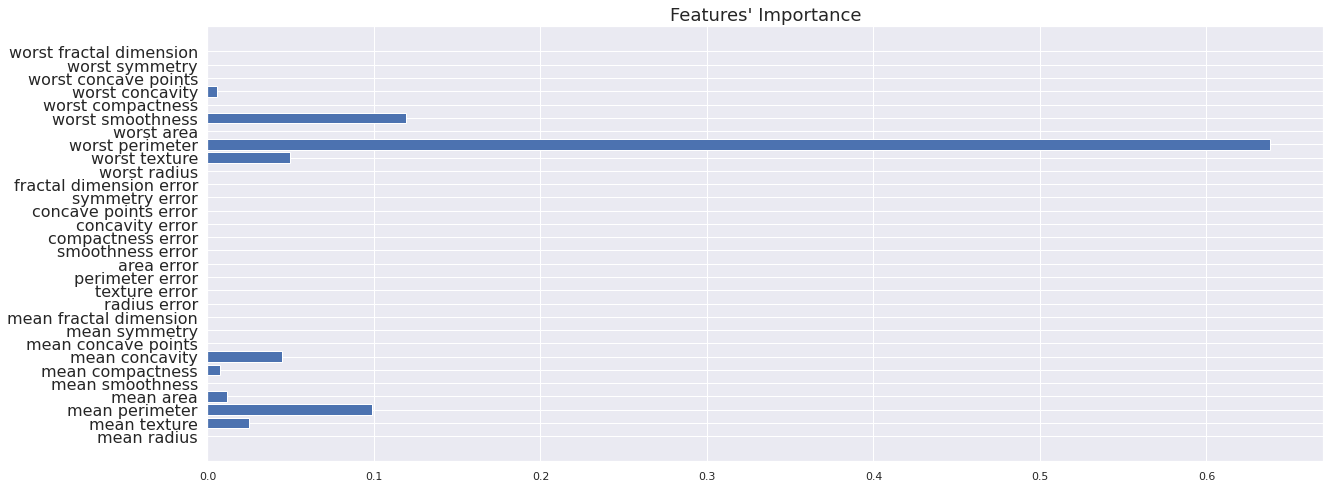

In [ ]:
model= DecisionTreeClassifier(random_state=11).set_params(**grid.best_params_)
model.fit(X_train, y_train)

def plot_feature_importances(model):
    fig, ax = plt.subplots(1,1,figsize=(20,8))
    plt.barh(range(X_train.shape[1]), model.feature_importances_, align='center')
    plt.yticks(np.arange(X_train.shape[1]), X_train.columns, fontsize=16)
    plt.title("Features' Importance", fontsize=18)
    
plot_feature_importances(model)

In [ ]:
y_predict = model.predict(X_test)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86        42
           1       0.92      0.92      0.92        72

    accuracy                           0.89       114
   macro avg       0.89      0.89      0.89       114
weighted avg       0.89      0.89      0.89       114



Overfitting을 방지하기 위해서 무작위로 여러 개의 의사결정 tree를 생성하여 aggragation(**beautiful randomness**)

<img src='https://jakevdp.github.io/PythonDataScienceHandbook/figures/05.08-decision-tree-overfitting.png'>

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAd8AAAFRCAYAAAA1uqfwAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz%0AAAALEgAACxIB0t1+/AAAIABJREFUeJzs3XdA1fe9+P/n5+wDyN4oKCKoOFBw771X1AzNMmnSNmm6%0A0nvbX27b22+b3tt729uRrjTNHqaJccS4F8uBA3CACqKIgMjeHM78/P4gAU8ARcY5jPfjv/Pm83m/%0AXwePvM77/XkPSZZlGUEQBEEQHEbh7AAEQRAEYaARyVcQBEEQHEwkX0EQBEFwMJF8BUEQBMHBRPIV%0ABEEQBAcTyVcQBEEQHEzliEaK6hMd0YzQS+Rk3cCj9teMiWr5bifLMh8dnc2idU86MTJBEATHCXKd%0A0+7PRM9X6HYRUeGczBiGzdayhHxvggvjpi51YlSCIAi9h+SITTZEz3fgqa9tIPnAVlyUtzFa3Rk+%0AfjnhkZHODksQBMFh7tXzFclXEARBEHqAGHYWBEEQhF5EJF9BEARBcDCRfAVBEATBwUTyFQRBEAQH%0AE8lXEARBEBxMJF9BEARBcDCRfAVBEATBwUTyFQRBEAQHE8lXEARBEBxMJF9hwLNYLDhgozdBEIRm%0ADjnVSBB6ozu3izif+C5eulsYLS5YXaYwb8XDzg5LEIQBQCRfYcBKP/ZPnl6T/+WrGgqKDnE6yZ8p%0As+c6MyxBEAYAMewsDEjlpVUMD7plVzY4SKK+7IKTIhIEYSARyVcYkLQ6DQ1GTatyGa0TohEEYaAR%0AyVcYkNwGuVBYM4b6BltzWeIZLUOjFzgxKkEQBgpxnq8wYFmtVuL3bEdtvY7Z5kLo6IVEjo52dliC%0AIPQT9zrPVyRfQRAEQegB90q+YthZEARBEBxMLDUShF7gVMJRGisvYZM1hI6az4hRI50dkiAIPUgk%0AX0Fwsvg9nzIr6hAhsRIAyecuk2X7FlHRY5wcmSAIPUUMOwuCE8myjKrxNCGBUnPZrDgjBVePOjEq%0AQRB6muj59iOZ6WncyTmIVlVHnSmIqYuewNPbo9vbKS0uJT3pM/TqcgxmHybM3oBfgF+3tzMQWK1W%0ANMqGVuVqhcHu9a3cPLLTvkCjqMJgDWDawkdx9xzkqDAFQehmIvn2Ezev56KqeJNNS80AyHIxb+6s%0AYPVTP+/WdsxmC2cP/o4t6yq+LMnjnZ15LHrsVdRq8XF6UCqVisrGMOB6c1l9gw2zMrz5dVVFDTfP%0A/ZHNS+sAsNlu8uaOQlY//Z9IkvT1KgVB6APEsHM/kXMpgdmTzc2vJUliyqg8cnPyurWd04kJbFxc%0AZle2YVEppxMTurWdgWTC3C2883koSacl9idq+CQ+jrkr1jf/PPX4AR5aVNv8WqGQWDwln4zzl5wR%0AriAI3UB0VfoJidbLtZUKGYvF2q3tmIz16LT2vS29TsJkrO/WdgaSgKAAlj/+MyoratBq1Ux01dv9%0AXJZNKJX2v3OPQTL1ZXWODFMQhG4ker79xNBRs0hJVza/lmWZlMtDiIga1q3txE6fz75E++SwL1FP%0A7PT53drO1+Xm3ODorjc5tvMfZJzvn4cfeHm74/K1xAsQOW42x88p7cr2H/chdtpkR4UmCEI3Eztc%0A9SPnT5+kIv8IWkUNdebBxM7bjK9/90+Eykg7R0nOF+hVZRgsvvhHrGLMxLhub+crVy9egNI3mDPZ%0ABMClLAU36zcwec6iHmuzt0k7lUhNwWE0ikoM1iDCxm0gYqRYCywIvZnYXlLoEbIsO2TCz9HPfsum%0AJdl2ZZ8cCGDuxld7vO27VZRVkn7yKJJCInbGYjy8xGxjQRDad6/kK575Cp3mqJm2GmXr58kahWOf%0Ad169dJGaG//k0bkGbDbYfTSZoHEvEB4Zed97jx/6HEtVCmpFPTXmMKYsegZvXy8HRN0zqipr0bto%0A0WpbH8koCELHiOQr9HoN1iFYrQV2k45qzIMdGkPBlS/YvKwRkFAo4KEl9Xx0YDfhkT+6531nTyQz%0AcfAehk1rei3LV3hn999Z8fgrPR90N8vPvUnmyXcJ9btNTb2eOmkSC9ZsFsudBKETRPIVer1Zyzfz%0AzmdlRIddQ6+VSb8WStyiJx0ag15V2apMp6po40p7tcVpDBvX8lqSJIb551FVWYtnHxu2zjz5Nk+t%0ALvryVQN3ShM4lRDI9HkLnRqXIPRFIvkKvZ6Li45VT/6YO0VlmBpNLJ8a7PAY6i3+QLVdmcEScN/7%0A5Db+ixnNStRqZRtX9153isoYGVrI3QskAv0kjBcuAyL5CsKDEkuNhD4jMMiX0GGOT7wAUbEb+HC3%0AJ7V1Niqrbby7y5voaRvve19I5BzOXmxJwEajjds1o3B1c+nJcLudm5sLlTW6VuVWWi+NEgTh/sRs%0AZ0HoIJPJzOmkZJRKJZNnzUCl6tjAUUbaOYpvxKNWGGhkGPNWPdYnt+Lc98k/WDfzDJ7uTd/ZDyTr%0A8Rn1MqHDwpwcmSD0TmKp0QBzM+c6ORf2olNWU2cOYPqixwbEJvy1NfWcPZ6Ai5s7k2ZMR6nsW0O7%0AvZ3NZiP50B5kQw4WmwsjYhYTNjz8/jcKwgAlku8AUl5aSXbyL1i7qOmkHJtN5s2dQ1j91M/79azU%0AjLRz1N58nxVzG6iuldl5NJDZa/+9R051EgRB6Ih7JV/xzLefST+xn9ULWtbFKhQS82NvcTXjihOj%0A6lmyLFN87XPWLjKgVkv4eiv4xoZizsRvc3ZogiAIbRLJt9+xoFDY93DdXGUa6lufGdtfmM0W3HWl%0AdmWSJKFTlDgpIkEQhHsTybefGT5mFifT7J91Hk7xI2bSBCdF1PPUahV1Ru9W5Y02HydEIwiCcH8i%0A+fYzwyKGUa15jE8OBLLrsJYP9g4lcvLz/XrykSRJeIYu52CyGptNpqHBxjs7vZkw8yFnhyYIgtAm%0AMeFK6DdKi8u4cDoetdaNqXMXiL2H78NqtXJs90dorZdBkjCpxrJg9WP9emKeIDiSmO0sCP1Ewa1C%0ArqYlIim1TJ6zlEHurp2u69CO91k3PRE316YBsMpqGwfSlzB/1cPdFa4gDGhitrPQ5xiNJq5kZFNb%0A0/pEo95AlmUsFotD20w7lUxd9qtsmn+MjTP2c27/zyi4VdDp+nS2y82JF8DLQ4HSlNEdoQqCcB99%0Ab5udfuZ2QRGXz8WDpCJ25hK8fMS61HPH4zEW72bCyEqykl2pkmczb+Ujzg6r2fHDX2CpTEKvrqOq%0AMYRRU59wyC5P1fkHWLbMAkio1fDo8lo+OrSbwaEvdKo+uc3v3mLIWRAcQSRfJ7pw9jTKivfYNN/0%0A5RmxJwke/xJDI4Y7OzSnqamug8rtPLTYCKgZFmoiI+swVy6NYdTYaGeHx4VzqUT77Wbk1K9K8nhv%0A9z8ZMvRXPfqsVJZltMrWJytpFPc/Wak9Fs04KqoO4+3ZlISLy2Rwjel0fYIgdJwYdnaiipv7WTDd%0AjCRJKJUS6xbXcy39C2eH5VRpKSdZOM1gVzYmSqLwRrqTIrJXUZDKyK99N5o0spCcrJs92q4kSdSb%0A7U9RkmUZg/X+Jyu1Z/6qRzh0YSmfHgrmk4MhJGatZPaStV0NVRCEDhA9XyfSKto6I7Z12UASEjqM%0AnDyJ6MiWsrp6G2pd63W8zmCRNciybNfLrapVMSjIrcfbDhu/kX/te5OVc6qpqoF9JwYzd23nh+Ml%0ASWLeyo3A/U9nEgShew2Ynu+t3FscPxpPTVWts0NpVm8JtHstyzL1ps73ZPqDEaNGcCJzNLV1NgDM%0AZpmP9wcxbd4iJ0fWZHTcIvYntxwHaDLJXC4YSWCwX4+3HTlqNNPX/oaDmY+TUfUCq5/+BR5e7j3e%0AriAI3a/fLzWSZZl9/3qdcaHpjI6wknhOj8llFVPnLXFaTF+5mXOdnDP/YMXsMhoaJfYdD2L6ipfx%0A8fNySPt5129wLW0bLspiGq2e+IUvY2zsJIe0fS9Wq5XjRw5ia7yFTfJm2oJVuLjanxtrs9k4e+I4%0ADZW5aNwGM3XOXIdtJJJ7LYfrF/ejUdRhJJQ5Kx5Go1E7pG1BEPqOAb3O93RyEpOC3yPIv6WTvyde%0Ax6h5/4PbIOcfaG42Wzh3MgWtTs+EyRMdtsGBxWIh/pNXeHx1yzD3oeMaAsb/nMDg1r3vxkYjCV+8%0Aj6viOlZZh85nGp5+QyjIzSJi9ASGDh96z/YK829zJfUYIDF2yiICgvy7FP/n7/+RNbMuEeCroLzS%0AxqdHRrBuy4/FBhGCIPQaAzr5xn/+No/OP2VXVlFp5fit55kyc2o7d/V/pxKTmTv8HTw9WnqLsiyz%0A9dgCFq59rNX1e7a+xpNLL6JWNyW3rOsWzmeYeWSNnnMXJbJKZ7Nw7eNttpWZnoqt+G0WTDcCcPC4%0AHpfQbxI1ZkynYr9yKZMQ+Q+MGNaSaG8Xy6SXPEvc9GmdqlMQBKG7DehNNhRaPxoabHZlmTlqhg7w%0AQ8DVGi2NJvsymw0kReuhW5PJjJ9LVnPiBYgarkKrsQIQN05muHcyBbcK22yr+PoBFs4wIUkSkiSx%0AdFYjhVf3djr2wpvXiBhqXxYcIFFdlt/uPdezr3N0z+fk5uR2ul1BEITu0u+T79R5S/hg72Dq6psS%0AcG6+jdyKKV0e9uzrJk6JY29SEHcPfOw+6srEGZ17Fj4lxsqVC2lt/qytWd0aRXWn2gEYFTOZU+n2%0AXxIuXoUhI8a3ef3+T9/Eteo3bJqzB03pf3Nw+zudbrs3yr58haO73uLwzve4XVDk7HAEQeiAfrnU%0ASJZlUk+lUF2WR/CwsSx//Kfsjz+CpbEU76BoFq+f6OwQnU6hUDB1+ff54MAnuGmKMZi9CB+/ss0d%0AtjQaNWWGKMzmlmHnazdM+Pm0JMDUSwoio9tOfg3WIKAl2cqy3Gqm94MIGRJM/MVFNJ48ytQYE2mX%0A1dysmsGidVGtrr2akcmUEacZFdH0euIYGYXiJNezZzM8su9vZnI2+SjB6k/ZtMCGLMscPH6OhroX%0AiRg50tmhCYJwD/3uma/NZmPXu79j7ZxsgvwlruTA2evTWbJhi8Ni6I+aJlx9gKvyBhabhqtZdWx5%0AqIqwwRKZ2TKpudNZsuGZNu+9XXCb88f+wuJpd7BaJQ6nBDFl2ffwC+ja8pzykgquZlwkYtTodkcy%0Aju7+lE3zDrcq35q4nAUr17Vbt8lkRqGQUKl69/fThG3/wSNLS+zKPjo4moUbfuCkiARB+Mq9nvn2%0A7r8snXDm+HHWz7uKv29Tr2xUBNTUnaIgbxGDwwY7Obq+S6fTsnTjN5pfz5VlLp5L42TCDULCx7Bk%0Aw6h27w0eHEzg469yMfU8CqWSFU+N65ZZyT7+3syYP/ee1/gPieJ63iGGh7W0l3HVTMmdMmw2GwqF%0A/ZOX2uo6kvb8Az+3G1itSqosY1i8/tleex6yRlHTqkyrbF3mbCeO7Mdckw5IaDxjmT5/sbNDwmQy%0Ao1IpW30GBMER+l3yra+6hf8E+z+UsWNsfJaSMeCTb3lpBWeOvMcgTT4Wmysu/rOZPKdzm1dIksT4%0ASbFAbIeuVygUxEx6sOH+hoZGKitqCA7x63SyHjthPJ9/MA6F4iLDhkhcv2ni4uVGnllxmk8/bmTV%0A5pfsrk/e9xZPr7yCQtHUXn3DaXbtcWfhmkc71X5Pq7OEANebX1utMg3W3vU5Tzq4i+nhewgJbPqd%0A3iq8wYkjFmYsXO6UeIoKi7iY9A7eLvkYLXrM2im96uAOYWDod8nX0y+CgqJ4Bge1fJs9la5idIx4%0Azntq/195Zm3el4mslszsbVxK9WFsbO/73RzdvRV3ThHsW8+x44GERD/KyLHjOlXX6sdf4r2//J6R%0AgecYEqxi00NNu0KNHpzBndslBAa3DFl7qHObEy+Aq4sCjTW7a2+mB42euon3Pv8HM8YXUdeg4OzV%0AcBasb71UzJnk2tTmxAsQGgKnMs4Azkm+5+P/ydNrvpoZX0vhncOkJPozdc48p8QjDEz9LvlOnDqF%0APVvPMW3keUaPgFPpSgob5hM5wGc33ykqI3ponl0PMjpS5uKRFFJNJipLC4gaN4UhQ4c4MUq4mnGF%0A00mJrJh8hugoJaBk4thStu75gBGjf9Op4V9JkggNdWfNfPv9l4cEGLlabJ98LbIWsD9D2CprO/NW%0AHGJwWCghoa9yNTMbva+e1U+FOjukViTMrcoUUusyRygrqSQi2H5JWkigRHLGJUAkX8Fx+t3DDkmS%0AWLX5O1Tof8TWxFVoh/2ceSsfdnZYTqdSKjFb7IduzWaZnCvnifF7k01zD2C+9SpJB3Y5JT6TyczO%0Ad/6HIOv/8d2NZ8m9ZSAlteV0o2njy7iaea3T9Xv6jyU3336994kLvoweaz8r2OYyiaKSljmIF68q%0A8Ro8q9PtOoIkSYwaE8XQ4b0v8QIYiMRobPndGww2GqXWM9MdQafXUmdovRWoTdY4IRphIOt3Pd+v%0ARI4eSeRosdziK77+XpwsGMG0CdmoVE1J+J9bG/nhs1pcXZq+g02bYGN/0hFqaxYxyN3VofEdP7Sb%0Ap1dmo9MpAImVi9zYsbcOq1VGqZQoLFbjO9Kn0/VPnDaVo7tvcPn6KUL86rh8M4DgUY+0ms08b8UG%0AThwdhOXiRWyyCu8hM4iZMrmL767rEvZtR6o/g0oyUG0KY/rSb+Dp3XpZWG80f82TfLzTjKt0FYB6%0AeTSLHtrklFjcBrlwu3Ys9Q3nmj/3Cae1DBuz0CnxCANXv1tqJLSvoaGR5H0f4KLIx2xzparazLcf%0AzrO75vYdCxk1P2B8bOeer3ZWwq7XeGTBJbuy8xmNeHoo8fZSsS0+hpWbvtPldhrqDZSXVREyJKDP%0AzHJNSTxKbNDHDA5q+tIkyzLvfjGC5Zt/7OTI+iar1Urivp0ozdcxy3rCRi9ixKj2Z+sLQmcNqKVG%0AQvtcXHTMX7MFq9WKTqcl6eBe6upzcXNtSULns1yJnO34zSfMshc2m2w32enqDRVm9Tg0gyJY/uiK%0AbmnHxVXf6oSk3q6x4iKDJ7b8XiRJIsQrl/q6BlzdnH84SF+jVCqZv2qDs8MQBjiRfAcIm83Goe1v%0A46G8iFplpqR2GJMWPsuHey+ycmYOIYESJ9OUNKgdP+QMMGXeGt7Zmcmm5aXo9QrSMyVUvmuYt2St%0Aw2PpKKvVStKBz1GYrmO2uTIiZilhPbBnuK2N/6YmiwqlqneuPRYE4f5E8h0gEvZuZ93MFNzdvhq6%0AzObdPe+ydstPSD99lkMXcvHwG8rkuROcEp+7pzsLH/1/fJFwGLOxirDIycyaGumUWDrqwKev88j8%0AtOZnh/uSrqJU/Xu3rycPGDaLcxlXiBvTNEPYYLBR0hCNTtd7Z2ELgnBvIvkOEEpzdnPihaahSw9N%0A0wk/dVW38deeINJzH+f2+KD2W87k2T0zAUWWZU4cPYS55jJWuWmiy/CopiSr02mZs3Rlj7Tb3Sor%0Aahjqfak58QIsn23gw8MHGRz2bLe2FR0Tw8VzT/PxoUSUUiNmxXCWbBAz+AWhLxPJd4Cwyro2yrTk%0A5uQS7r6P2LEyoCFyeC37E3dQWT6pzUMWuuro5x+xcHwCAb5NXwQSz1zmmu3FPjfhpb6uAS93E2A/%0A9KtSNPZIe+PiJkOc82ddC4LQPfrGdE8nqqmqJSXpJMVFJfe/uBfzGzqH1MyW71rFZTJm7SRyr5z5%0AMvG2WDzTROqp5HvWdzPnOoe3/ZbjO/6dI9v+h5yrWfeNwWKx4GI915x4AeZMNnLrytEHfDfOFzIk%0AgEu5IXZl+bdlXH0dO0tcEIS+SfR87+HEkX3ojfuYM76BjKsazp+cypL1Tzs7rGYN9QasVluHJkiN%0AjY0jM13J1kNJqBQmlG5jmb9qCSeOHaGm1or7oJYeXF6hTEBI+ztdGQxGbpz7G4+v+GoD/0q2HXid%0AoMG/vufsW5PJgl7bumdoMXb+bF9nkSSJ0dOe5f0v3ifYu5CaehdM2qnMW9m7N+QQBKF3EOt821FR%0AVkn+2f9g8cyWbfBybsrctHyHsRNiHBJDZnoaxTlfoFOUYbD6M3j0OqLGjMFkMnN4++sEDbqCWmUl%0AvzycGcu/jYeX+wO3YbFY2PP+L3lm7W3UaomGBhsf7BvB2i0/afeexIMHWDVhG3p9y8CJySSz4/Rq%0A5i1ffc/29n/0a55efbP5dVW1hQ93GNH7TmfZI9/utacH3UtdbQM6vabXHz8oCIJjiXW+nXDh7BnW%0ATzEBLUOkEUMlzsRngAOSb2V5NQ35b/PYUuOXJbf47MCbDBn23yQf+JTNi86j1TYlP1m+xnt732bZ%0AY99/4HZUKhWLH32FbUd2o6QMWRXMisc7O+np/icPTZj3DO/ufpMQj2ysViu19TZeeMqN+oZ09h7c%0Aw7zlazrZtvO4DXL8WtuiwiIundiKq6oIo80D36GLGRc3xeFxCILQOSL5tiMsIpLMaxIxo1vKqmps%0A6NwCHdJ+2qljPDK7kbsT2qp5texMisdFkduceKFpCHSQOq+NWjrGxUXHgtUdnz07Zc48du48zKaV%0ALefG7jwyiCkr7z9DOjA4iIkLXqA47WXmTNY0954HuUkoTLkPHvwAJMsy6Uf/wpZ1X81DqCbx9Hvk%0A3wx2+sEYgiB0jJhw1Y7wEcNIvT6eO6VNG8LX1dv414FQpsye65D2lSoNZrP9E4FGo4xGq8dia71D%0AkxXH7dqk02kZMeU7fHggih1HfPjoQBRhE1/o8M5RHp5uNJrd7YatZVnGZBvUUyH3K5fSLzF/UpFd%0A2ezJJrLOxzspIkEQHpTo+d7Disde5HRyMoZL11HoAlj55GKHPdebMmchn+2I5/HVLZORth/xY8nm%0AWWSmu5CamUtstBWA3HxQekx3SFxfCQ0fRmj4jzp1r06npU4xnZv5Rxg6RMJmk/nsoDvjZvWNNb7O%0AplQqsVhbl8vy/Yf9BUHoHcSEq16sML+AzJSduKgrqDf5MmH2RvwDm86ezUhPpzj3OBI2BgVMYNKM%0A2Q9Ud8shC7ewyG74Dp3P2NhJPfE22pV6KoWa4gtYZBcmzliBj7+3Q9vvq2RZZs/7/8mz6243n898%0AMFlLwPifEhTimMcigiDc370mXInkO0B98cFveXplVvPxgmcuqDF6v0Tk6L612cVAVV5awdljH+Gq%0ALsJk9SBk5DJGjhVrjAWhNxGznZ2ssdFISsJRLOZGYqcv6JGdox5EeWkVI4KuNSdegMnjzWw9nDhg%0Akm9W5mUKrmfgHTCMmMlxzT3IvsLHz5ulj7zU7s8vnE2lvDAVq6xl3NSlBAQFODA6QRDuRyTfHna7%0A4DYZCb9nw+JKNBqJ/UnxuAx5mugJsU6LyWK1olbZ+PrSIEmyOSegr8nKyCD/ygE0yjoMtlBmr9iM%0AXt99hwgc/OwdYoedYPY8iVuFNna9N5q1T/2wzyXg9iQf3MXYwL0sXvDlEHV8GsZxPyR0WJizQxME%0A4UtitnMPy0zZwRNrqtHrFSiVEivnNVKc84VTYwoI9OHKraHc/cQhM1vCd0j3rhMtvlNOVWXtA91z%0A83ou1qK/s3lpFhsXFbJpwUmObPtjt8V0K/cWo4JSiI5sSrShIQrWzLpC6qlT3daGM1mtVuSaZKK+%0APNlQkiRWzW8gO22vcwMTBMGO6Pn2MJ2yvFWZvo0yR5u+/EXe2/sugzQFmG0uuPrPZvKc7umNl9wp%0A4dzh14kakkdpo5rk8lEsffhF1Or7f9xyLh5l80JT82uVSiI67Bp3bpcSGOzX5diyL19i0ywrd/f6%0Ag/wlqjNvAo6dMd4TjEYz7i71rco1ijonRCMIQntE8u1hjVY/oMCurMHS9STSVd6+Xix77Ac9Undq%0A/DtsWZtP08CKFaPxItv2fMKidZvve6+C1mtoXHQ2jI3GNq5+cKPGTeBU+m6mT2wZYr9VaMPbP6Jb%0A6nc2FxcdJTVB3P2ZMxptGCWx+YYg9CZi2LmHjZ+5gXd2+lBTa8Vkktl+wJWQUWudHVaPkWUZd3W+%0AXZlWq0Ajd2z3Kr+wyVzKsv9YpmUPISy8ew6oDxkSTG7VHM5caGrj8jU4lDqBmCmOXWbVk0bEbeaD%0AL3zJvmHhVBp8cCCauSs2OjssQRDuInq+Pcw/0J9Fj73KkeQkjI0Gpiybd8+Tf3qTtFOnqC4+j9mm%0AJXrSEkKGhNz3HkmSMFtdAPueqsXWsfc8ZkIMr//ahctXi9DrJMorbVRZIzsTfrsWrtnErdyZfJSQ%0AxpDwKFZt7l8zvIeNiGBoxH+RfeU67hGDWDVHzHQWhN5GrPMV2pS4fztxoQcID23qze5PdsEn6vsM%0AjQi/773JB3cxcfBewkO/fH1Wg83vW4wcO/a+9549cYLYwLcJ8m/p/WZkQZXrvzFiVPcmYUEQhJ50%0Ar3W+YthZaMVms6GoP9mcPCVJYvlsA9cvHujQ/bOWrOVqzRY+PjKerYfjUIZ8v0OJF6CmPN8u8QJE%0AR8rczLn6QO+hPTabjTPHT5F85Bgmk/n+NwiCIPQAMewstGI0mnHTtZ4xq6Ljy4Zip02nM7OHA8Oi%0Aybp+hKjhLbORT6apiJ7Q9WeyZSWlpOz7A6vnFqPXwe7t+xg68XmGR4ketSAIjiV6vkIrer2Wkppg%0AuzKDwYZZObTH244eP5bTOdM5c0GBxSKTdEZJft18ggcHdbnutMRPeeahEvx8FLi5Kti0sprcC591%0AQ9SCIAgPRvR8hTaNnvYk7+1+k4mRhVTWaMi+M4Zlj6x3SNtLNjxDQd5iPkvJIHpCLFGB3bM0S68q%0AabWLlYuyuFvqFgRBeBAi+QptGjJsKIOH/oqb1wvxCXNl1QIvh7Y/OGwwg8O6Z3nRVxotXsBt+zKb%0AOElJEATHE8POQrskSWJYxGB8/R2beHtKVOwaPt3visUiI8syB5M1+IUvd3ZYgiAMQGKpkTCg1NbU%0AczbpADarhfFTF+AX4OvskARB6KfEeb6CIAiC4GBina8gCIIg9CIi+TqYwWDk/NnzlJU4/2QjQRAE%0AwTnEbGcHSj2RgKl4J1PG1ZB1QUtq9WQWr9/Sbw5xF7qXLMtse/MoGYl5aFyULH1yMnEzRzs7LEEQ%0AuoFIvg7SUG/AXLKDtYsMgIqgACt5BSdJTxnNxGlTnR2e0Av9/Zc7OP77PFQ2DQBZR/by3Xdh0myR%0AgIXWsjI9kgqFAAAgAElEQVRucuSzVLQuKh56di7ePh7ODkm4B4ck34sVhY5ople7cvo8T8TVAcrm%0AsrDBErsvnkUVNXDOWh3nff+TkdqTEn+IxvJTKBUmGmzDmbf6CTQadTdG5zwXKwrJK6tsfm2z2oj/%0A9DJ6W8syL6lUz5t/PcSdQFtbVThcwdXbFFy6zcjZI/AMEH/onen8ngwu/t8N9DXuTcvo3n+NJb+b%0AQUC4v7NDG9Cen9D+hCuHJF+NKtYRzfRqwUP9uXzjC2ZMbDksvrHRhqwZM2B+PyZLKhcrCjuVgM+d%0ASCLa7zMi4pom5xuNd9i63cDyx17s7jAd7mJFIWmX86iqjiTc1rT0yWoxY63Z0+paS7ErctYYR4do%0AR5Zl9r75HpUnS9A16sn6azIRq8YzfeUyp8Y1kF1+/zD6GnegaX2+Ps+Ls3/JZ8U35zs5sgFuQvs/%0AEsPODuIXMoSUM9OIGJJEgJ8Co9HGG5+HMmr1Q84OzWE0qlhMltRO3VtbfIaIcS2r4rRaBZ6aq1it%0AVpRK5T3u7BuqqiNZ5x9tV5YYHUTF8brmOQEWycykKTGMD3Tu+bwnk5OoTSxHb3MBCVxq3bi5/xKP%0ArF+Ft5dPl+s3m03s2PopRdeKcPVyZfH6ZYQNHdYNkfdPNpuNj6qMgP0okLbB5vTPitA+kXwdKHbt%0Av7P91HhIvYxZ4cfIlRvQ6LTODqtPkGi9HP1B56mdPR5PXXEKSsmMRT2SuSs2oFD03gn/T37/Wd6T%0A3+TOlRLUOhUjZ0axar3zv6zlXs1FbbP/3CortFxITWXewsVdrv9v//0nSuIrUUhKyqnhjfS/8/0/%0Avoyfr0gkbVEoFPgM9aGu3NhcJssyPmFd/yIk9ByRfB1IkiSipy8Fljo7lD5H7xvLzfxshn75eNxs%0AlqkwRna415t6MpERgz4manxTEq+uzePznfUsWb/lnvfZbDaOHz6ItfEmVjyZOm81bu6uXXovHeXr%0A48fLr/5/NBobUSmVqFS94/l2YGggGVxBdVdPy+puZGR09D3ual9B/i12vruNioIqNIPUFGTk4y0F%0ANv9cKtRwaOd+Nj/3dFdD77fWPrOej6rex5hjRVbb8I5xZ8NTjzk7LOEeRPIV+oQps+dz4kgjpy+n%0AoJSM1FmHs2DdUx2+v6YohajFLb1nj0EK9LZL971vz9Y/s3HeRTzdFVitMu/uuMD8h3+Bi4uuU++j%0AM3Rax7XVEXMXLiQ16SwVKbWoZQ0mdSOjl44iKOjBn+VbrBbeePXvyNea/hRZMGORLZgxoZaaZnlL%0AkoTJYOrW99DfRI0axc9f/xXnzpzG3cOdUaPGiCWMvZxIvkKfMWPhcqBzByFIkrVVmQLLPe+5lXuL%0AieEZeLo3DU0rlRKPryxlZ8IB5i1f26k4+gOlUsmPfvUKxxMSKLp1m9ETxjB2fEyn6jqZlIQ5W0Z1%0AV57wI4QyivCj6Uxpk7aRmBkTuyP0fk2lVDF12gxnhyF0kEi+woCgcB1DafkN/Hy+nLxkkamxjLjn%0APUUFBcwaauXu5WFarQKbubL9mwYIhULB7Pldn0krt/EsH0AdrKCxoQ69l46Zy6czITauy20JQm8i%0Akq8wIMxavIrDXzSgMqajkMzUWYYzb+037nnP2NiJJB4YxNpFDc1l13JlfEPG93S4A8aM2XM4FnkE%0A27WWMmtQI6/+7X/RaLRotbpePSlOEDpLJF9hQJAkiQWrHwUe7fA9Li46dMEb2XZgJxOiyrhe4Ea5%0AZQYLVosh0O6iUqp45pXn+fy9HVTkV+AR4MHiRzbi4dE/zpAWhPaI5CsI9zBh6kzMsVO5cS2P8BkB%0AxHi4OTukficsbBjf/fnLzg6j37h6JZPEL+IxNhgZNjaclQ+t7dLkq6wrl9n97i7Kb5Xj7u/O3PXz%0AmT57VjdGPDCJ5CsI96FWq4gaPdzZYQjCfWVducz7P38fZXnTTPGi5NNUFJfx1AvPdao+s9nEh797%0AH3LVqHHBUGzh84JdDBsR3qnZ7UIL8TBFEAShn0jcG9+ceAFUspqryVkYTcZ73NW+k8nJWG7Yl6kr%0A9CQdjO9KmAIi+QqC0A/V1FZjNg+8tcGmhtbv2dJgxWzq3O/CxdUVWWF/kIeMjEanaecOoaPEsLMg%0ACP3Gtawstr3+LypyKtF6aJiwdCIbHu/4JLu+LiImgsLEE6jklt3HfEf64OY2qFP1xU2ewoGxezFe%0AkFueG4eZWSQO0egykXwFQegXZFnm49c+wHxFQs8gqIdzH6QREhbCtFkDY4LQklUrKSsu43LiZcz1%0AZvxH+vPEd5/udH2SJPHSf/6Az977hIr8Ctz9BrHs0VWdTuZCC5F8BUHotLq6Wg7v3Y/FZGHesoX4%0A+jrv/NibeTeovlqPCy0z0tVmLZfPZg6Y5CtJEo8/twXLFjMmswkXfdf3Iff08uYb3/92N0Qn3E0k%0AX0EQOuXG9Rze+n9vQL4aCYm0L9JY//JG4qZMcUo8Hh6eKF0lqGspk2UZtUvvOJCio86cPEX89qPU%0AltXiE+rN2i0bGBb+YLPtVSp1rzmIQ2ibmHAlCEKn7P/XHhQFWhSSAkmSUJXpObrtsNPi8fbyYdjM%0AMKzyXXt2DzazZG3n9gN3htu3C9jx++3UpRuR8jVUnKjj3f99E6u19d7kQt8mer6CIHRKTUltq7La%0A4tZljvT8y99hd9h2Cq4WoHfXs2T9cgICg5wa04NIOhiPqlwHd+2JYcy2cfZ0ClOni0MT+hORfAWh%0ADyouuUN1VSUREVFO2/vYe7An9ReL7XZP8hri3G0hlUol6x552KkxdIVC1frfUlbY0GjF0p7+RiRf%0AQehDLFYLr//Pa+SdLEA2gFuknse++zhRo0Y5PJaHnn6Yv+W9huGKGcmmQBVuY/VTjzs8jv5k4cql%0AnD9wHmVR0xnOsizjNkbHhIniVKf+RiRfQehFTCYTKpWqVW/WYGigrr6OxINHuX24DJ3UNIvVmgXb%0A3/iUV/7wnw6P1c8vgJ+99itOnUjGZDQyc85c1GrH9tBkWeZa9lVkZCIjR/X5A+S9vXx46mfPcGjb%0AfupK6/AO9WbDM4/2+fcltCaSryD0Ara6FF7+zYfYbjSgdFMRNmMks9etRpZlCq++y7ihqQT5GbiU%0A4oFSCre7tzSnglPXc3BxfbC1l+MDA7oct0KhYMasOV2upzPKykv5x6//QlVG0/Rmz2g3nn/lBfz8%0Auv6+nClq5Ciifub4kQxnys66wsWz5wkZOpipM2YOiC8bIvkKgpON8w7htXc+xuW8DnCHGijYlc3F%0AmH/h5dPAtOEJlJfBmJkq4mJrOZNpf7/Kz4pu7A0ktfKB2t15rYxwm2+3JGFn2PbmxxjSregkFwAM%0A5618+s+PefGV73ep3uPxCaQcOIWx3kjwqGA2PfcUWo22O0IW2vCvdz4gbdt5tI0unFOkc2JaMj/4%0AxY9RKh/s89zXiOQrOETJnWKOHj+G0VaEKS6WuJgoZ4fkVOkpp6i8fQaQkFxGU5HaiBu65p9rzDpu%0AnSjicmEux6+MRGl0Y+sf81nzbDEpwTeQCochSRJGTQPhq0NQPmDiLS+pAQL7bOIFKL1RatdDkiSJ%0AstyyLtWZeuYMe36/F3V9079FTmYe/6z+K9955YddqldoW1lZCem7mxIvgNqmpfxEDfGHDrNw2VIn%0AR9ezRPIVetyNnBzePLkTyzg/JMmHX2Wm8kRxGRuWDMylE6cTDhHl9RlLF8kAnEo/j1UV2uq64uw6%0A3K4NRyUpQQJrQRgHPzGz8Yf1HD7mB2aZsAkziIqZgJz1YDF4A/P6cOIFcPV2pYr6VmVdcfbY6ebE%0AC6CQFOSnFtBgqO+W3aIEe1cyM1FUqe2WVqlQU5RX5LygHEQkX6HHHTqbgHW8f8v/r1Af9l64NmCT%0Ar6HsBFGxcvPraROUeEWXY07xRCk1/Ze0+DQS6h9MdY7B7t6ya34U3vHj3370PYfG3BkJh4+QevQc%0AFpOFYeOHsf7xR7t1KHHeugV8mv0J6ko9AGZPA3PXrexSnbJNbqOs7XKh68aMG89en71Q0bIbl1ky%0AMSRiiBOjcgyRfIUeV28zAfZb3VXZLMiyPCAmVnydUjK0Klv2iI7Tnt5cSbqMucGCS6MLcoUFlexq%0A/zvytLJg/o8cGG3nHI9P4MAfD6E2ND0rPZ+eQUP92zzdyUPd2zJx8iR8/+BH0v6ms2VnLZ1LWNiw%0ALtUZM2sCeclfoDY2xS3LMkHjA3F1dbvPnUJneHl5M2X9ZE59fBpNrR6zxkjI7ABmz5/v7NB6nEi+%0AQo8L1HhQbDUhKVuWz4SpdQMy8QLUW4ZitVagVDa9f4tF5npFCGVZ5fgZBjcNwdWD4Wod5sFVaAsG%0AoZRUmFwMzH54Pjqd3rlvoANSE841J14ApaQi+1Q28re79wtXaOhQHv/mlnZ/XnyniJMJyfgG+jFj%0A9pz7bkgybdYsal+s5dyhsxjrjQSNDOLxF9qvX+i6dY89zJQ50zl7MoXwyAjGjotxdkgOIZKv0OM2%0ArFxP8UdvUOBrRtarCCqs45srFjk7LKeZvXIL7+5sYIj3dWyyRGZJCBWKOAy5J9BLLSMEetwIiwki%0AZONgqsuriZ0xmRGRPTtR7cypk5w/no5SrWTWkjlEdnLzDpvV1qGynnR4736OvHkEdZUei8JMUkwC%0AL//6J/f98rJ45XIWr+w7+0H3B8HBg1mzYYOzw3AokXyFHqfV6/jhN75Lwc08KqvOsn79dKdtidgb%0AuLjqWfn4j6iva0CSJJTGCvIOGMj3AGparpNlGXdfD5atXu2QuPZ//gWJryehNn450zfpbR756aPE%0ATIx94LpGTh5J0umTqKxNXyZsso3Q8aHd1us9d/o0F0+dR61Xs2jNUgIDg+1+bjabSPo0EU21C0ig%0AljU0pFnYvW0HDz+xuVtiEISuEMlXcJjBQ8Pwt5QN6MR7N1e3puUVGMHVw5Oo+SPI+fwmKlmDLMso%0AIiwse2iVw+I5e+BMc+IFUFXpSNqd0Knku3TVKgy1BjKSLmE2WggbO4QnX3ymW+LcvW07J986jdqk%0ARZZlriT9ked+9U27Y/dKSotpuN2Iy11zDRSSgorCim6JQRC6SiRfQeglnnnpWySMOsKNS9dx9XJl%0A+YbVDBrk3iNt3Sm+jUajxdvLp7nMUGNAhf2QrKGm9eSwjpAkiYc2P8JDmx/pUpxfZ7PZOLf/HGqT%0AtrkdZZGWIzsO8tyPXmi+zt8vAH2IFm7dda9swyfE5+tVCoJTiOQrCL2EJEnMW7SIeYt67nl4cfEd%0A3v7tPyjPqELSSAyOC+JbP/kuWo2WgMgAym5XNw8N22QbwSOD71OjY5nMJgyVBnTYb6XZUNVg91qt%0A1jD3kXkc/udh1JVNz3zdY/WsevghR4YrCO0SyVdwqJJbBRw+9hk6ZRUNZn8mzX8Ub1/nHkPXFbIs%0Ak3nhOiqVipFjhjo7nPv6+G8f0JBmQY8bmKAkvopP/D/kyW89y+YXnuTt+jcozShHoVEwJC6ER57u%0AXacU6bQ6fCN8qEs1NZfZZCtBka3P7F24bCnj4yZwIiEJv0B/ps2YJR55CL2GSL6Cw9TV1GK78gFP%0ArDQCIMv5vLWjkBVP/rJP/lG8nV/Kfz/3EcWnjUgKCJ6h52fvPI23T9NQcd6NIrb/I4HGajPRs8JY%0AvWm205dXFecU2w0tKyQFd67dAZpOKfrx//6M0rISNGo1Hh6980vRhm8+ykd/eJ+arDoknUTotBAe%0A2tT2Gb5+fgGs3bjRwREKwv05JPleunXHEc0IvVzhqe38akMjX+0lJ0kSK2bd5u/btxM6vu+d4vL5%0AKwcxndCi+/K/UdkxmVe+/zYrfraQ0pulHPjeCXQFngBc/Pgc8SmXWfDSLMJ8vRjnHdLj8V3PyeZ6%0A9jWmzJyBh3tTHHp3Peav7dynd7d/zuvn69/jsQFU11Sx9fX3Kb5WjN5dz/QVM5g1f16719tsNvbt%0A+pybGTcJHBbA1NVTmRA7qUfjPXf6NMl7EmmsbSQoMojHvvGkOGRB6BYOSb7aXEe0IvR2qkozX99d%0A0M1Fwprnh6wb45yguqA28yB3/xmWJInaSxJy1hhS393anHgBNDYtBXuquTrfC6IrAXosAdtsNl7/%0A7WvcTMxHbdBx7N145j8xj8WrVjBl2VTibyU2b4Bh9TYyd41zdhN64zd/pfqUAUlSUIeRvdf24+nt%0AxdiYtjdZeOcvb5CzKw/Vl3+20vefJ3lUEt/88YsMHtJ6b+yuupyZwfb//gxVTdMM8GsXbvKP8j/z%0A3Z/1/h3GhN7PIcm3L5+cInSfYOUGDiUeZ8lcY3PZjv1+LJ++zuGHsHeHA37u1BUY7cr8AjwZHxjA%0ACYuC2q9dL9XLBNXpaTSFAIU9Flfi0aPcOlSEVm5a46oo0xO/NYGZC+eyZPUKfAN9SUtORaVWMXv5%0AXIZHRPZYLO0pKy+h+EIpeqll4pS6TkvKsZNtJt/6hnqyk6+hwaW5zFcOoiSzkA//9C4/+d3PO9Ru%0AwuEjnNxzgvrKevzC/Xj0m5sJDGp7UtnJg8nNiRe+PGThXCHV1ZW9dkhe6Dscknwv3Cl2RDPCA8rL%0Az+F6WQ4+em/GRsY54LmriuL8x7n24X483SoorQ7EqNuIqbyyh9vtGWFzJ3Au5xj6WhdkWabRq4Gw%0AuXO4cKcYVag3ZopQ37XOVBPmwiAPL0z3qLM73MrKQy3bf5mx3ZHIvHSJSZOnEjt5CrGTp/RwFPfW%0A9Oy79fPv9p6JNzTUY61rvUOWhETZ1Uoqqyrw8vS+Z5tXMjM48NpB1PU6FGgpL6jhrep/8Mrvf9Fm%0Au23tyCVbwGq13rMdQegIhyRfY9f2Ohd6QMKxfeR6V6Me6821qkIupWXy0JonUKp69iPhOWwqMJUq%0Amo5aUAPGe9/Sa4UPi0M/wYes/WdBITFt5TT8hg7GCIx/fhFldaWUxecjV9vQjNYz7QdrMIVLRAX3%0AXK8XwDvYB6t8A6V01xi/l5XwiIgebfdB+Hj7ETTRn8rj9c2JzzLIyNQF09u83tfHD6+RHjReaEl8%0ARrkRJSpUrgr0HdjvOiX+pN1xgQCVmbXk5uYQHj6i1fUTZsVyI2FH8xC9LMv4j/XF29u3w+9TENrj%0AkOQ7NjTQEc0IHVReUsItXTnqsKaJKipPFxqmKim9nsmiRUucHF3fMjY0kMULprX5s3F/epm6mlrq%0Aa2rxDwlqTjImS2GPTrhasnIFF0+epy7ViEpSY1I3Mm7ZWHx6WdL45k9e4qPX36U4pxiXQXqmr1zM%0AmHHj27xWkiQ2f/dJ3v7tG5RfrcQqW5CR8ZL8iZw5rEOHTbR1nKGkBLWm7Ucek6ZOpfLbFZw5cBpD%0ATSOBkQE8/sLTD/QeBaE9kizLPX5QZXzRA570LfSolORktikuo3Kz7wWMyVHzxPpNTopq4DBZUu2S%0A78WKQo6d0rLOP7rb2rBYzBw7dJjyojJGx45hfMzEbqu7PWVlJRzbfxilUsnClUubZ1h3t/Pp50g5%0AfAqzwcywscNYsW5th5Zw5d3K5fWX/4aqvOlzL8syHtP0/Nt//UePxCkIU+eObPdnYp3vADR6zFiU%0Ae0/B2Jbka6k2EObT/TNGBedQqdQsXu64k3nSzp5l228/QVna9JlK3ZfG0z97hsio9v/4dFbMhDhi%0AJsQ98H1hocPY9B+bObbrCA2VDfgP9+eRZzu+icj5tFSS9yRirDMyJHoI6x9/FJVS/AkVOkd8cgYg%0Ady9PZvuOJuHKFRQj/bAV1RBepGbm03OcHZrQRx359BCqMn3zHCrlbS0HP9lH5M+7P/l2xdiYmHaX%0AMt3L5YxLfPLqJ6iqmp7/Vpy9TFXZ3/nmyy91d4jCACGS7wC1culKJt+ZxNlzpwkfGseoZX1vna3Q%0AtsZGAx+/9QF3su+g99Aze9VcJk6adM97TCYTJ5IScXVzJW7y1Aee+V5bWgt3zewGuJySye5tO1i9%0Ase/vp3x8f1Jz4gVQSkpupNzEYGhAr3e5x52C0DaRfAcw/8AAVqx0zFmxguO8/ps/U5pYjUJS0ICZ%0AbRnbcPsvNyJHtr2L2JXMTLb+3wdYcyVsChsHx+7nOz//AV7e9166czfvId5U3LJf2Ww12Dj1z9O4%0ADHJh4dKlXXpPzmYxW1qV2Yw2zBYz95/qJQit9b0NdQVBaFdFRRmF54pQSC3/tVVVWo4fTGz3nj3v%0A7YKbapSSCrWswXhBZvv7nzxQu2u2PATDzVhkMybZSJGchye+qCwaMk9e6vT76S2ip4zBompZoS3L%0AMv5jfHEf5OHEqIS+TCRfQehHLFYLNkvrBQxtlX2lPN/+gHlJkqjIf7BD58PDI/jpX35BpecdGqgl%0AkFC0UtPkK0UbS3z6mjkLFjBlSxyKcCumgHp853iw5eXnnR2W0IeJYWdB6Ef8/QLxH+dD7Vlj8/Ib%0As97IxDntzw5293fHUGw/rOruN6idq9un1eqInTOZ3M8LWjbO0BmZMCf2gevqjdY+tpG1j21ElmWn%0An04l9H2i5ysI/cyzP/4WAfO9sA02oYtWsvDF+UyMa3/C1fwNCzF7G5BlGZtswxZqZNmjqzrV9pbv%0APMfoTSPQj1HhHqtn8fcXMXNu/5pF35HEa7PZOLhnL2/94XW2fbCVBkO9AyIT+hKxyYYgOJgjNtl4%0AUMXFRSQePIZaq2bxyuW4uro5LZavlJWVsOvD7VQVVuEe5M7qTQ8RGBjk7LA65K+/+QMFh0pQocIm%0A29BEw09+//N2jyMsKSnmX3//gOLrpbh46Jm2cgbzlyxycNRCdxObbAhCD5BlmYtp6ZRXlDN9xkx0%0ALn133mtAQBAPP7nZ2WE0s1gt/OU//4jlsgJJkqimgb9l/Ymf/vmXaNrZDrK3uHnzBreSCtF8OQ9a%0AISkwZlo5vGcfKx9a1+Y9b/3P6zSkW1CgobHAyqGbh/AL9GPs+Adfkyz0DWLYWRA6wdDQwP/+4/e8%0AX3mS/R55/PJff+J8epqzw+o3kuPjMV622Q3xWrIl4g8fdmJUHXMr9yYKg32/RikpqS6rbvP6/II8%0Ayi9V2ZWp63WcTTjdYzEKzid6voLDFN8uYl/yYWptjQRoPFi3Yi0aXdvDcL3drv2fUz7ZG5Wy6fur%0ANTaIPakJjI+ZMKAm41itVj5590NuXriJSqMiZm4Mi1eu6HK9DXX1KLCfJa1AiaGuoct197S4qVPY%0AH7QP7rRsOmJSNxIdN7bN6zUaTdNf4q8tJVYoRd+oPxP/uoJD1FbX8Od973F1pEzhaC3nhtbz5w9e%0Ad3ZYnVZqqkH62h/HSp2Zhrq+ObGmwVDPFzt38vlnn3HwwF6S4o9hsbbeWOLr3n/9LTI+vIohw0Jt%0AWiPxf0ni6IGDXY5n7qKF2ILsTz62+Dcyd8nCLtfd01z0riz/xgrkISYMcj1mXwMTHxtPzMS2Z30H%0A+AcRGOvH3dNvLN6NzF42z1EhC04ger6CQxxOOIxpYkDz8ekKlZLCYJmcrCwioqKcGltnuCv0FMj2%0Aw6JujQr0rn1vq8HsrKu89+u3Ib+pp1ZKIXrcOBp5mOd++m0GD2n/wI3rZ66jlFqewapMGi4ev8CC%0ApV07mtLV1Y1Hfvgo+z/aS2VhJZ7Bnqx6eD2enl5dqtdRZs2fx9RZM7iRm0Nw8GAGubnf8/oXX/k+%0AH7/1AcXXinHxdGHOmrWED+895y8L3U8k3wGqtLiY8+npREdHEzxkSI+312gxteopSu5aKsofbDOH%0A3mLl/GXc2PEWhol+KDQqbNllzAmf+MB7IvcG+z76AkWBtvlQhACGUCwX4H7Ni13vfcZ3fvpDAM6n%0Ap5KTmU3E6MjmXpzNZuPrW2jI1u5ZQBETF0tMXGyfXVerVmuIihzdoWv1ehee+c43ezgioTcRyXcA%0A2vnFDk413ECO8ObgmUzGnfDnyUef6NE240ZPIC17P8qhLfsFu2TVMPGpBz8arjfw9fPjlSe+x9GE%0AI9QbDUybtIEhQ8MeuJ5LqTm8/X8HKMw2UxYxhA1bHnugPZW7Q3VRNc2Z90uKL59IVeRXAvD6//2Z%0A3EO30Jh1nFWnkbLoBN/60XcZNmEoNwtuN29naVGaGDWtYwmno/pi4hWE+xHJd4C5U3ibk4YbKEb6%0ANf25jfDlwu1KMi5eZMy4cd3aVkNdHTv3f06FtQF3Scs0zRAupt2kTmvFp1HD6inLUKnV96+ol9K5%0A6FmxvHObUQCU3Cnnd09vR77pih41eVeL+GvBn/iP3//CoQnHM8SDsus1dmU2bAC4B7iTcekCuYfz%0A0Jibls5ozDpyD+eTsfgCT7/0HB+q3yHv0i1UGhWxsyaxdNVKh8UuCH2VSL59THV5JWWlJQwdEYGy%0AE3vmpp4/hxTpa1emCvbgam52tyZfWZb50wevUznVF0mhQZZtuKTk8JMnvovNZsPFzXXA92h2vp2E%0ALdeFr34NkiRRm9HApQvnGRczwWFxrHpiHW/f+ie23KbPUym3GYQn1qBGljz8KFczMtGY7Ncwa8w6%0Arl3OYsy48Wx5SQyXCsKDEsm3h8iyzKFDB8ipLESLinmxMxg+YkSX6nvn43e5rCjD4qHC84SF9ZMW%0AM3bc+AeqJ3J4FMeu7UcV2jJxxVpZT4jv8E7H1pbUM2coG+mCStGUWSRJom6CL0nJCSxZurxb2+qr%0ArBZbG4USRqOxW+qvqCjn07e2UpZbhpuvGwseWtTmQfLhwyP42eu/JOHwERoa6jE1jkatUrNgxRI8%0A3D1RqhWk6M6gaWxJwEatgdEx4gxoQegskXx7yEfbPuJCcD2KwKaTXa6n7eZZVhExIrJT9R05cojL%0AoSaUg/xRAoZg2HHmENFjxj7QJJ8RI6OIOpNEtmsdSh83LNUGBmeZmfr8jE7F1Z6KygoUfjq7MoVW%0ARV1j31yK0xOWPjaVk+9+iFTq2lymj1Tdcx/mjpJlmb+/+hqGdCuSJGGkhq1ZH/G9P/kTGBjc6nqt%0ARsuSFW2vz42MGsWolVFc2ZOFplGPSWdg1IoRRI3s3me7gjCQ9L2pmX2AqdFIpqEQxaCW5GMb6UtC%0A6lCCYL4AACAASURBVIlO15lbVYRykH0yq/BXUJSX/8B1PffEN3jYZSITc3WsZRTfe+6lbh8CnjVr%0ANqpLpXZlclYZ0+KmdWs7fVn4iBCe+dMCtNOM1ATW4D3DjS0//kanHid83dUrmVRn1Nv9uypLtBzb%0A07kdop5+4Tmef+154r49nuf+9DxbXux7Q80VFWXkF+ThgO3sBeG+RM+3B5iMRoxq+PpUIiPWTtfp%0AKmmQZZPdH1NdtRVPX58HrkuSJCZPncZkei4R6l1dWT9mPvtTk6jSWRhkVDF3eCzBgwf3WJt90fxV%0AcfjOCOr2gxUsFgtf/7hJkoTVamV3yl6uGPNR25TMCIphysiO9bSHR0QyPKJzIzfOZLGYef1//0xe%0ASj42g4z3aA+e+OEWQsOGOjs0YQATybcHuHm4E2DQcvcKVlttI8M9O7+eduncxVzZ9Sam2EAkhYSl%0Aop6JusG4DnLM6TONDQZqq6rxDQrocC85Lm4SsbFxNNTVo3d16ZNrYB3pwp3ibqtL9gtEMUIF2S1l%0ABo8GbnhWUzzMjMqjaTOQ3NxTcEVmyqjJ3dZ2b/PZh/+i6HAZOqnp/0rjJRuf/P0j/u03/9Ftbdy4%0AnsORHQcw1DQSHBXMusceRqUUf16F9olPRw95fMl6Pjq0g2J9I2qzxHhdMEs2Lut0fT6+vry87nkO%0AJByiwWYkMiCamRtmd2PE7ft016ek1dzE6KbAqxI2TF3K6OiOTbaRJMlhXxB6g5LCIlQaNd5+vve/%0A+C7DR9yh0fRg99ybxJz/eoyUv++h4UYVGl8XYjYuIKXuAiqPltESaZgnx0+d79fJ93b2bRSS/VB+%0ASU4ZFosZlarrS90KCwp482dvoLzTtE958fEKSgqKefEnP+hy3UL/JZJvDwkZPIR/f+Z71FZVo9Xp%0AuuUAAS8fb/7/9u47PqrrTvj/5947XRr1ikBIICGKAFFN782mGIwbbrg7sbNJNrvP/rLZ12a9zz6/%0A55fdze4mu4lTbBP3io1twKb33kE0gYQKqHdppBlNuff3hxLEgJCEpJlROe+/zNEtXxXP955zz/me%0ANasf74boOu7woYMctZajS47FADQAnx3+lp+PGCl6sreoKCvj7W8+pDjCg+xSGWyz8L0nXsRoNrV7%0A7l/29jXo4ro3qMQ45kxtmd2saRrH1p2747DS6vI72voSS4iFamxebeZQE0o39Ux3btyKXGy4WadE%0AkRTyD12nqrqSiPB7fy0k9A8i+fqYNSw00CF0yaXCHHTDvHuuNQlGci5fIXXk3TeK7m8+/G49VZMi%0A+MsjVqFH5bON63n60acCGtetJElikC6cglvKNbrr7FR+k8dn9R/x6NonAhxh97ialcXmj76htriW%0AsAFhjJ2ZQcGZ6yhlzb8dl6GJaUumdNskQ6fdece1PHaVhoZ6kXyFuxLJV2iTWdajaU1eHy66OicR%0AnZjo1REet5uPvviEHHspMhIjwxJZ/eDqHl+Qo8RTB7QsGZIUmSJndeACuou1K5/g9X/+ZxrCdWD3%0AoDtsIz4/ljPbTvPgmtUYDb1zi8e/aLQ38M7/+3ZzrWokKrJr2VGwnRf/78vs/24P7iY3o6eOYfLU%0Aad12z/T7xpC9NRe9q+VnFzY8hIEJ915uVOg/RPK9i5qqKtZv+YoyTz3BsokFGdM7/J6zL1k8eyEX%0Avn4b54TmiVZqQxPDnOFExkT75H4fffEJ55IdyMbm959H6ivRbfqalctX+uR+3cUiG28b2ATzLbv9%0A9BTW0BCGNw2i7HflgA5JMoEEzho3DbZ6jBG9O/nu3LKteXemW57V1FyF7EtZrH3tRZ/cc8r06ZQ8%0AW8TJbSdx1DQRlRLBo99/osc/MAqBJZJvKzRN43efrWsujSiFUQu8d+pb/joiitj4bn4v18NFREXx%0Aw6Vr2bp/Bw2qk8EhCSx+svMTx9qT3ViCbGxJ7IrVRFbuva9l9repielsvXEReWBYc8OVSuaOnh/Y%0AoO4iIWMQxRtK0Ekt//uHDbES3oeHSH29snflmkdY/uhDuFxOTCZz+ycI/Z5Ivq3IunCBkhgNx9Fs%0AkCWs6YOQR8ew+/BeHn/osUCH53cxcXE8/Yh/3l3KrfQWfN2DqKuu4eyZ06QOSyMu4c7qT9C8dd6R%0AQ4corChmRPIw0sd6l/VcMG8hUaciOHE5E0WTmDVheZfKifrS4udXcvFkNtW7ipAaJaypFlZ/r2/0%0A1OYvWcSRDYfhRksPXk72MGfhAp/fW1EUFEUkXqFjRPJtRXZ2No3FVYRPHYamadQczcaSFI2q9bwh%0AufxruZw+f5pBcQMZP2lSr/8ATQsZyImGGpSg5lnCnqoGRkcP8dn9vtv2LXvKz+MZGg6HTzHGHc0z%0Ajz/jdYyqqvzqrf+hKM2AkmzhSNFexl4663Wcx+3m1KVz5DSVoqHhOLyb5wcO6tBsZ39TFIXFP1uL%0A4/5KBuh1DElO6TMz1y3mIJ752XN89/GmmxOulj31YK9/ly30PSL5tuJKfRERM5pn8kpAxPQ0qr47%0Ay4zHVgU2sNt8+c2XHHLnogyNYn/Fcfa9eYQfvvBal8sTNtpsZJ49S9KQoX4fZn905SMYNm3gSnYh%0AkiQxOmYo9y/u+kYMmqZx9PAhckuuEx8WxczZc6mrqWV3xXmk9NjmDeFTozhbWsuZkyfJmDDh5rkH%0A9u+jcIQRXUhzr0Y3IJRzjeUUFlwnIbG5cMpnX33OpVQPsjEegFyPyvsbPuLFJ57vcuy+EhoWSUpc%0AbKDD6HZpw0eQ9s8jgObf+9aNm9jy8WaMwQbmLl/I0JSeOSIh9C8i+baiRrVz68xVgIjQCBKTkwIR%0ATquqK6s40pCDMjIGAF1UMIUmB3v27GL+/IWdvu7O3TvZfv0EriGhSAcOk+6OZu3jz/itRy3LMg+t%0AWN3t1/3je29xJdGFbmgQJ+uzOfnWeUYnDkNLi/LaRl4XG8Lla9leybe4uhRdsvdwopwcwaVLF24m%0A3zx7GbIx7ObXJUXmurNvr5/tDd7/wzoufX4VndZcTGPd0bd4/l9eYGgnNzgRhO7SN8aaulmkbLmj%0ALdEaE4BI7i7r0kU8iSFebUqwieLaik5fs6HexvYbJ9HGxqGzmlGGRZMZY+P4kSNdDTegsi9ncSWi%0AAV1E8wOVYjVTNNxIg60B7Uat17Eem4PYUO+JR0PiBuOu8J7LrF2tYNy48Tf/refO0Qa91PUNEnqK%0AhkYbn777AX/8t9+y4dPPcLmcgQ6pXU3OJi7tvXQz8QLIZQZ2b9wRwKgEoZlIvq1YPnUhhuMleBwu%0APHYnxiMlrJi1JNBheUkbMRIlv86rzWNzMCC080uAzp4+jWuod1EQXVQwV4vyWj1e0zSOHjrE199s%0AoOh6z5uRrKoqmqZxJecKyqAwr6/pwiy49DC8PgR3ZXNi9TQ0EZNpY9bsuV7HTrzvPtKKDLgLqtE0%0ADc/lMqZZUoiMaXkgmzh4FGpx/c1/eyptZMSk+PC78x+328V//v2/cu6dS1zfUsLx35/h1//7lz1+%0Ad6CmJgfuhjs3M2lq6FkPDg6HnaNHDlJaWhzoUAQ/6pPDztlZWRzOPIGMxNz7ZjJg0L1taDAkJYV/%0AHPTX7Nu7G0VWmPHcWvSGnrVmMzwygqnWFA5ezUFOicJTYWNQrsbs5+e2f/JdJA8ZgnT0GKS0TBLy%0AOFxEBN2Z0F1OJ79a9xtK0kwoiRYOHP6UORdGsHRJ63vC+lPRjUI+2b6BYq0OC3qGWwagZVUgDW/5%0APtxFtYwaOp6R6ekcOXyQ3JzrRFvjmPfi/DvemUuSxMtPv0ROVhZZ2VeYMHMxsQPivY6ZM2su+oN6%0ATl24gAqkx6Ux/37fz7D1h13bttN4zoVOau5BKpJCxdEazp09zdiM8e2cHTgh1lAi08JpOOm62eaW%0AXAwZ47sJfPdq746dbF23BU+xhBbiIW1BKs//4JVeP3FSaF+fS76HDh/gq+LjSKkRaJpG5v5PeXrM%0AYkalj76n6xiMBhYsWuyjKLvHquWrmJiXz6lzp0hMSCdj/oQu/U8bPzCBkfsiuFBpQxcZjMfhIvxU%0ANfOff+aOY9e98xZl40PQGZs/kKW0aA6cu8C8hjmYg4LuOB6gsqKCDds3Uqk2ECqZeGDaAhKTkjod%0A7928u+VTaiZFImPFAZwsrSYpx0DBhVK01Ei0/BoyPLGMGt38NzF12owOba44NC2NwUOGsH/fXo6c%0AOMKMKdO9er/Tp89g+vQZ3f79BFpNefXNxPsXOpeBwoLrPTr5Ajz5V2v58L/fozKrCl2wwojZI1iy%0AYnmgwwKae7zb/rQVpcSEIgH1cPWraxwcvZcZc+YEOjzBx/pc8t175SRSRgTQ3GPRRkWz88zBe06+%0AvcWgpMEMSuq+MnbPrXmWI4cOkpNznQhzJAuefwaD0bvXn3X5MqdqrhFm9P6Z2uNM5OfmMTz9zn1p%0AVVXljc/fpn5qLJJkpQr4w45P+IfHf4AluPt2PSorLKY0QuXWhSVKrBVjtcZP5z/J2TOnGT5lCfED%0AE+752rXV1fzqo99TPy4SOdLAlq9/S1pTGD967cc9oqfibHKy7esdVFTZSBoczazFs7tlCdHEmfdx%0Acv1pDA0tk87c0Q5mzJ3T5Wv72qDEwfz0l/9IbW01RpMZk7HnLP06n3kWdxEYbvnT0WtGss9fFcm3%0AH+hzydemNXWoTWidJElMnd52T/DQuWMQbsbjcKGYWnpExsJGBk9LavWcY4cPUzMqFN0tSco5Load%0Ae3awfFn3lY40mk0oTeod7XpkIqIimbug40PBVy9ncfzCKQyyjoWzF/DNzs00TI9H+fP3EDJ5COe2%0AnuXb7zaz9IFlnY75XFUhAJkFJZ2+hsft5tPffoIjKAVZF8zpggoOHv0dK56/+8zxtNEDOZt5o/2L%0AW6wMWTWGq9vOopZ5UBJ0jF4xjdwGBzQ4Oh2z39mdQG27h/lLgyUYt9WFwdbyqOjRPNjNum7d21kI%0AnCncffOZPpd8Y2Urhbf8W1M1YhRrwOLpizyohIxLpnLXeUInDUUfHoTt/HXmBg2765Czw2FHCr7t%0AXaoi43S7uzW20IhwhjaFkOt0Ixua/7ylSxXMmXRva7R37N7BltpMlJQINI+D0xv+QIhkQpLCvY4z%0Axoay5cD2LiVfgKyi5p74mOCBHTre3tjI9o+/pq60hqSxKTQqKnbzEBRd8yiFzhREeV0QwaUOhgy9%0A+8SvtNEdu1/a6Bdo+pGDirISYuMT0Om7vg+uMJCrK0dx9eMrGDxGPJoHw3iFJ378DEZTz+mhC76h%0AvP7666/7+iZ5tkpf3+KmwVEJXNh1BJvswlPVQOwVB8+uegpjN+ynKzRTG51cqMglKCMRe145jTml%0AxNfoefXFV+96zoCEgRzcvgs14ZYHofNlPDl7RbcOOwOMGzWWuhM5eApria6QeChjPinDOr6uU9M0%0APtizAc/I5s0dJFlCHWCl8UQeDIvyGmJuyC5BirQwO3UiBmPH/sY8ajGx5pZlYqX2eirrQzqceB12%0AO7966Z8p/qqYuvN1ZO+8zFVHPlrcbROJdEaiZBtDU7pn1rVOpyMkNAy5i0VcejK3y0VFWSkms9kv%0AVb9GT5+IZZgZolWSFw/lyZ++0mcTr8ftZtM7n7Ln/S1cPH6GqMRYQsLC2j+xF0uKibjr1yTND+sF%0Adhdn+foWXjRNI/tSFnqDnqSUoX69d09kb2xk09bNVLlsRBmsLF+yHEMXH0a279zG0RsXaFSdxCuh%0APPHAw0RGRbV5Ttbly2w8up2KP0+4GmZNoMJVj1N1kxaVyMKFi3vEu1OX08nff/RLlHHe74UjTlST%0AlZ1F+ANjUIJM1J3ORQk2oViMDL9h4IFFS0ka2v5MWqf7JGMiWq59rqqQrKIEjLkdi+/gxs0UfpSD%0ALLUkh9LgUrRlM9GHtvwOPGXXeGbJIoKtIa1dRrjN8ZNHOH2tAIdixuxpZGLqEMZlTAp0WH3Gxt+v%0Ao3FvHcqfN/Swx9lZ9rNnCY/yzQ5pPcErj8++69f63LAzNL+3FBu9N/N4PPzXu7+l5r4oJEUm21VH%0A9ju/4e9e+UmXEt3C+YtYyKJ7Oidt+HDShjf/XjLPnuGDnN0wIgJQyK/Jpearz3l01aOdjqm76A0G%0AojQLxUXV2AsqMEQGY06OYVBIDGNmprLh0mEkIHjkQHRWM1X7L5E3LY03znzF0qLxzJ45p9P3HtuB%0Aco9nnKpX4gUIrw8lQq2moLIRpzkcc2MlK8aOYHoP3dyhpykuLeJUQSnEpGAEVOBETh4rpkwjIuzu%0AvRehYyory6k7VY5RanktZSo2cePQcea8/FwAIwucPpl8hRYH9++narQVRWn+sJb1CmVpZk4cPcqk%0AKVMCFtf+iydgZMuHmhJm4dy1PB7RtB7R+w1zG7lRV0P4lFQcJdU0rD/Nyn/4BSaLmRsfFZNlqMbj%0AcFF1Nh9jfDiSIkNKJPtOn+5S8u3IRBt9YixNchZGtWV40h3nYd4DK3HYGykuvs7gpEmYTBYxcaeD%0A9uzbgxY+0KvUqCcykY93bmPG9M6vnReaFRbk4mnwHmSVJImiipo+/TfaryZcCd4qayuRB3u/Q1LC%0ALJQWlnXrfRrqbWzbvY1GVxPj00YzIj29zeOdmhvwnrTThBvV40HRBfbPsrKsjOwQG0HDm7cXNMWF%0Ao1sykpOnTjBz1mxeeupFyktK+dV7v0U3PxVZ1/IOtF61o3XyAaKjk5+GpSdgrywna+MFtCoJfZLC%0Asr96iNET/vKKpW8uq/Ol4vJBXDxdjmJsWU6lOhpJnzC0w78X4e5SRw3g6AebUM+3tDn1DqaumNpv%0Af76ivGQfd9/4yahZtxX4v1TG1Pumdep6l86fZ8vmzVRXVt1sqygv5xcf/4bDA2s5l+LkrdwdbNqy%0Aqc3rJFvjUBtaloBpmkaCFBrwxAuQmXkOKdl7VrMuzMKNypalQAeOH6TcVoN026ScGNnq8567JEk8%0A+b9e4a+//DmPvfMMP/3y/2PqYtE764qZs2cT6SxCU5uXqWmqh1i1jMlTO1J+RWiPLMs88rO1GCfo%0AcVgb8Ax2Mv57k5g0d2agQwuYPjnhqi/Iy7nGoTNH0ckyC2bOJ6KdyUxt2bZzG3tvnMUWJhFSrTEv%0AeQJzZ8+7p2t4PB7eePf35MV7UOJC4GIZC+IyWDR/Ee999gHnh7m9ko7+dCn/9MSP71qWU1VV3v/s%0AAy45inArMMAdzNrlj7c7acsfyktL+bc97yPfWo6y1s6D2nBmzZ7DyePH+bjyMISaqD6YRfCogShm%0AA9arNp6es4qUdnbM6eqEK8E37I0NHDiyH1uTmxCTgZnTZmHoQUU5+ooGWz0mk7lHPGj7Wr+bcNXb%0AHTi4n6+LjyGnRqGpGqc3r+PF6Q91esnIovmLmNM0h4qSUqLjYztVp3rXrh3kDdehC/rzsqD0WHaf%0AOc3MxhnUaw6k28oPNgZJ1NfWERHdejKVZZm1jz+Dy+nE7XZjtty5k1SgRMfGMsk4mGO511GSI3GX%0A15OYqzHjhVkAnM/PQklt3oAicsFo7Hnl2HPLeW7qo+0m3rspzK9gVdydlcG6i81Wz2frPqLsWhlB%0AkUEsengJaSNG+ux+t8u7nktJeRnj08dh6GF10m81ZUjPqfvcd/W9PaQ7QyTfHmhv9gnkjFvWmGbE%0Asu3YHr7fhfWaBqOBAYPvbYOJWxXWlqGL8e4FOAYFkX35CnHGMPKctTeLWgCE1cuER0Xefpk76A2G%0AHrdpBcCjKx9hUnYOZy+eZXDCKK+62SZZj6a6kWQJSZKwJMdgcEvExPSsbSdv9Zt/+S9sx5xIkkQD%0ATt658Cd+/KufEBsX3/7JXeD2uPnVB+9w1aFDMwbx2eETPDFzGhPHjPPpfQWhpxPvfHuges+dJfvq%0A1cCW8Ys0h6I6vatRGUrsDE5OYsUDK0g4a8dVUIW7rhH98RJWjJ/XI2Ytd0VyylBWrniIcRMmen0v%0Ai2YvxHCy9OaWeh6Hi6G2IGITBgQq1DZdzc6i6kyt1/eglBrZuXmbz+/9zY4tZCvRKGGx6MzBOKKG%0AsP7QEVT1zhKggtCfiJ5vDxSjs3Lr5HtN1YjWBbZE5uIFSzi/7tdUjglBCTbhLqhmalAyIeHNFWp+%0A/OIPuHb1KhVl5Yx7ZmKP7M12l/DICP5q6Vq27N9Og9ZEgjmKZU+1XV7y2y2bOVmShVNzEy97WLNi%0ABkFW76H2riy5aGt9cJPDgXZbFU9Jkiipqff5Mo+zRaXIFu+HknJVz95LF4iI9O1IQZPDzpmzJ7CY%0AgxiVnuGXilWCcKu2lhqJCVc9UG7ONd7duZ661CBwuInJd/PampewhvqmUlFpcQmlRUWMGJ3eZtL0%0AuN3s27eH8rpqMoalM2zkCJ/E09fs27eHjc4LyNHN78s1VWPg2UZ++Kx3Oc7ObqxQmF/BEDWq1QR8%0AtqQUVVX5+t/ewHOupd0Z4uCZt77P0BFpnbpnR73/wcecqrZ4T8aryeNf/tcrHS7H2RlnTp/ho017%0AcYYMQnU5iHSV8uPvP0doHy9nKPQsc0bdvcKi6Pn2QMlDh/CPSX/DuVOnsERbGLZkpE+GcFVV5e0P%0A13HZVIMaaSLogx08OGYOkyZObvV4Radj7ry+sUG8P527cQV5VEv9akmWuC7X4Wi0Y7K0rCsdnRjX%0A+Zu0MVN6xNhErP/yCl/910dUZFcQFBXEnMeX+TzxAiy7fxFZb7xHQ0gSkqKg2iqYMjLJp4kXYNOO%0AQ7jDk5EBWQmmxhjEl19t4rlnn/LpfQWho0Ty7aEURWHcJN/Wld25cztZyW501uYlNa5IKxtP7GF8%0Axvh+sQzAXxTpzuFOWcXnGxRUVVdyaMsW6irTmDh7Bj/4n3/w6f1aEx4Zyc9+8hJbtuygweFg7Izx%0AjMnI8Ok9PW43lQ1NSC3PNUiSRGV9L9r+UOjzxCdsP5ZfU4ISY/Zqq43TUXAtj+Rh3bMTjgCTUseQ%0Ae/0I0qDm5Umq002KEonB6Lv34ru3bWfrH7egqzST/+EF9k3Zxg9+9Q8B2THHEhTMQ6u7b8/m9ig6%0AHWFm/R0794YFiZ3NhJ5DzEDox6yyCU31fuVvqnET3YHi/kLHTZw4mZWR44nNbCDsXC3j8sy88Piz%0APruf2+1i9ye70Fc1v2vVe4w0Hmhi87uf++yePc2C6eOhugBN01DdTsw12Sx/YGGgwxKEm0TPtx+7%0Af/4SLn76e+yTYpAUGXd5PRNNiQSHBHZmdV80beoMpk2d0alzC/Lz+WLPJso89VhlI7OGTWTGtLuX%0A5SuvKKPhuh0LLb9HWZKpzvffvtqBNn3GNFJTh7B//2Es5iDmzX+1z+6T2x1s9fVcvnSJ1GGphIaF%0At3+C0GUi+fZjIWGh/N0Tr7F111ZsbgfDB0xg8oKu1bKtrarG2eQkOl70nruDqqq8s/UzGu6LAYKp%0ABb7JOcGAq3EMuct2gVGR0VgGmOD6LdfRVEIT+tdM35jYOFY/vCrQYfR4mzZ+y54z12gyRWDYeoyp%0AIxJ4WPzcfE4k334uyBrMQw+u7vJ1XE4nb360jmuGWjwGmbgaHc8+8DixA3xbQamvu3Quk5pkk9f+%0AT9LQCA6dPX7X5KvXG5jx8Ex2vb0Lfa0Zt+TGPMnI0uce8U/QQq9RWlTEzjN5SOGJ6AHNHMyBK6WM%0Az77KkBSxF7QvieTbzzgdTXz81acUOqsxSTqmp03gvsld39f3y40byB2lRzHEoQBVwEfbvmDNwof4%0AZMdXlHpqscgmpieNYd6c+V2+X39hNJnA6V0NStO0VmdQ32rx8qWkjx/Lho3fMWzcUKbfvwDFx7Or%0Au5OzqYn3PviUvNJaFEVmbOpAVq1a0eurpvU0R4+dgLAErzY5JJZTZzJF8vUxMeGqn/njx+u4MMxD%0A7dgwSscE80XxEc6fO9vl6153VHjVdgYodtfy9uaPKc4IQp0wANu4CL6rP8/5c+fuchXhdinD04gt%0A9HhNjFMyy5jfgQ3eExIGMnPlCmYtW9yrEi/Aunc/4oLNSmPIYOqDBrH3WgNbvt0a6LDuiaqq2Bsb%0A8UMdo04bnJSI2ljj1eax2xgQ13PrlPcVIvn2I7baOvIMdUhKy69dSgrn8KXTXb62Rb5zGYdW7aA8%0AzrunIieGcSLrTJfv15+8+tiLDL8M4Zl1JJ5v4tlJK4jp4zPSr5XUIt3ywKCYgrmQcyOAEd2b7dt2%0A8PNf/Ia///e3+T+/fIPMc5mBDqlVY8aOJcnUgLvJDoDH1cQAqYIp0zq337fQcWLYuR9RVRVVgtv7%0AQKrW9SL3c8ZM4b3zW9GGN+/G5CmtZ0LCMI657qwdrATwmU/TtF43dGkNDeH5Nc8GOgy/UmSJ28pR%0AIyu94/eWffUK3x6/hhSahAxUAx99s5P/PSINvb5n1TyXJIkf/uAVdu3cRVFpJTERoSxc9P1urYOt%0AaRo7tu/g2vVSgs16HliykPCIiG67fm8lkm8/EhIexkC7mZJbEpBaXMf4IV2vpDVyVDovG03sPXkQ%0ANypjEidw36KpFL/135R41Ju9beliBXOmPtzl+92rzVs2c7z4EnbVSZwSwhOLHyY2vgvlHAWfSkuM%0A5nRlE4q+eURFbaxm/KTeUfjl6PEzSKHNf1uapuF22HDqozh+5AjTZs4KcHR3UhSFhYt8twb67XXv%0AkVljQDGGoDVqXHjjPf7uB2sJ6+dLmsSwcz/z4uq1DMl0YThVRsiZKhYbhjOpGyZcAQxJSeG5x9by%0A0mPPcd/U5iVLrz7xEqOu6ojIrGPQ+SaeGbOYQUmDu+V+HXX0yBH2yLnYx0fDxARKxln50+aP/BqD%0AcG+efvIxpg2QiHIWE+cpYcWERObMnR3osDrEbNSjqR4cNWXU5JzBWVuJvSyf02cvBDo0v6uurOB8%0AUQOKMQho7mnbQ5P4bsuOAEcWeKLn28+EhIXyvadf8tv9TBYzax972m/3a825gsvIad6FQ0rDPJQX%0Al4r1yD2Uoig89pj/R0i6w+LFCzj+X29RU1lHeMq4m+1XGuvYv3cfM2f3vN6vr1SUl+NWzNw6vzSO%0A+gAAIABJREFU2C5JMo0OV8Bi6ilEz1fwUllaRlH+9fYP7EV0rfyZK07Vp7WVhf4rKNjKo0umYYrw%0Afq2hWEK4lNO3/t9qz5DUYYRpdV5tHnsdw5IHBiiinkP0fAUAmuwOfv/xW+Rb7ah6mdjtEs8/sKbN%0AIhmNNhtGk6nH74A0e/w0sk59jZbWPBlMdboZ4gwlNKJ/v3MSfGdI6jBM3x33atM0DZO+f/V3FEXh%0AkQdms/67fVSqZsxaE5OSo5gx6+7lUfuLnv2pKfjNZxvXU5gRhF5pHp6tSYZPtm/gR2tfvePY3Jxr%0AfLr3G8oNDkxumYmRKaxa/pC/Q+6wISkpPNO0mD1nD9OoORloimT1E/cWb86VKxw+dAgXHhIGJDB3%0Azjz0BtFzFloXGhbOiPhgLtY7kA3NNaUNtfkserj3VBmrqijHZDZjCQpu/+A2jB2XQfqY0RRdLyA8%0AMopgq6gdDyL59ltVlZVs2vkdtaqdGH0IN+yVSIp37d8Sz+2bsjU/vX+w60tsk6PRAW7gYFkR8YcP%0AMWVqz10bOHJUOiNHpd/zeZqm8eZ7b3ExpBbD2ChsF4o4dO0aR3LO8tdPfB9raIgPou1/3C4XqqZi%0AMPSdbf9efOEZNm/6lrziCoKMOhatfIi4+J5fbvV6fj7vfbaREruMHjcjE0J5/rmnu7T8SFEUBiUl%0Ad2OUvZ9Ivv2Q09HEf3/+Jo1T4pAkA9c9jTRsLiA4wzv5tlY4ozA3n8pYiVu/osRYuXDlKlPoucm3%0As44cPkhWogtjRDQA1tGJ1J3NpzrRyqYd37Jm9eMBjrB383g8vPPuh1wurMbjgcRIE8+vXUNISO9/%0AqJFlmeUrlgU6jHv2wfrNVJoT0f95q+/ztQ42bdzMigeXBzawPqZ/vYAQANi5ewcN46NurvWVFBkt%0AMQx3ZtHNY9QbNUxNHH3HucGhIegaPV5tmqZhkPrmc1xuyQ10EUFebcHDB2DPLaPW0xigqPqOL774%0AinO1ZjzhyRCVTD5xvPdB/9l3uKdpbLBRYvP+/1s2mMgr6j/bUfpL3/zEFNpU72hENuq92oJGDmDC%0AJT1NVyQ8msb4lJlkjB9/x7lhkRGkNIWR7XChmJqvocssZ8HcJ/wSu7/FhUZxypaDEtyyF2xjbhnG%0A+HCiHb2/dxZouUWVKPqWWcGSJFFQaQOah6J3bN9BSWUtg+KimDNvbq+rUd0bVJSV8dmGzZTV2gk2%0AKsjupjuOMRvFz727ieTbD03JmMSxk1+gpEbdbNOdL+fBx36I2WJp9/yXnnyeb779husN5VgwsHD6%0AauIHJrR7Xm80e85cTr2ZSdEIFX2YBfuNShz5lQwPNbP82RWBDq/XM+juHHwz6mRUVeU/fv07iuQ4%0AFIOF02UVZF56kx//8HsBiLLv0jSNN97+iBrrELBAHVBXlUNwSDyKuXlilK72BvOWLLqn66qqyuef%0Af8mV6+XIksTYYYksW/6AD76D3ksk337G4/GQmJzEkryx7Dt1GptFI6xB4f4x89pMvLnZORw8cxQJ%0AiVkTp7FqRc+d3dydFEXhJy//iIMH9pN/+Qau2iAmLHiK0eMyel2N6J5o+sTRfLL7PFib36mrDhvj%0AhiVy5NAhCrVIdH+eKawYLVyzOcg8c4bRGRmBDLlPOXfmDBVyhFcisKZNI6b+MuFhAzDqFeYtvZ+k%0A5HubLPXxx59zvFRCNjU/lG+/XI0sb+GBpUu6MfreTSTfXq7kRiFGk4nwqMg2jzt05CC7Lh+jRrMT%0AKVlYOm4O/zTrJ9hq6wgJD2szkRw9doQvCg4i/bmnfO7o56ypmU9Gxri7ntOXyLLMzFmzESsTu9/k%0AKfeh6HQcPpmJx6MycswgFi5ayPrPv0Rn9l6SogSFk5dfIJJvN9JUlds3PJQkieQhQ1mzpvPLoi7n%0AlyGHtJSRVcxWMq8WIPq+LUTy7aWKbhTyznefUhaporhUkhuDeeXJF1tde1paXMJX1w4hjYtBAWqA%0AT05s4eepaR0qNLEv6zjSmJYhaoZHszvzcL9JvoJvTZg4gQkTJ3i1ZWSks/+zvSihLeU/tZpCJj+y%0Ayt/h9Wljxo0jcut+6mhZ6SDX3GDO6q79nLVWnuXVnrutcUCI2c691Cc7NlA7ORLj0Gh0w2PJH23i%0Ai41ftnrsgaMHYGS0V5trTDQHDuzr0L1s6p0TMGyq896DFoQOSkkdxoxhkUjV13Hbbcg1BcwfO5jY%0AON+vk3U6m9jy7Xd8/Ml6si5f9vn9AkmWZV5e+whJcjmW+gLi3CU8+cBU4gcM6NJ1UxMiUV0tnxGq%0Ao4FRQ7t2zb5G9Hx7IU3TKPHUIdEyLCfrFQodrS8HMBtMaK5aJEPLr1trdGIN7lilmRjZSsFt94/V%0AiSo1gm898shDLKiuIifrKmkjlmINDfX5PRts9fz7r9+k2jIIRW/kyJf7mTvyKitX9t01rgMSEvjh%0Aqy906zWfeuJR5E8+J/tGCbIskT40geXLl3brPXo7kXx7IUmSsEh67Le1m6XWqwPNmzOfIx/8mqb7%0AmnsNmqYRdrGeSa90bCvBRxet5M2v3qd8kA5UiC3y8Mjq5wC4npfPwdNH0Esy82bOJzxSbJItdJ/w%0A8AgmTrnPp/c4sP8AR89cxun2YK8upT5qNIrcvLRGCYnlYGYeixc1dmglgNBM0el4+qk1gQ7jnqmq%0ASvGN60RERWG2BLV/QheI5NtLTU4Yxa7iHJT45rWm0qUK5ma0PpPQZDHz2rK1bNq3lVrVToQcxKrH%0AX+5wubjo2Fj+/uW/ISfrCrIsM2RZKgCHDh9gw42jyMOi0FSNkxvf5KWZj5A8dEinvy+P282ePbsp%0Ar68iLXEoGeMniFnFgs8cPniYLw5eRQqOAT1U28oIj2lZ06qpHsqKi/jtH94hJiqc5UsXEx7R+QfM%0AkuJi1n/1HeV1dkIsBhbNnsLoMXcWsxH87/SpM2zYso9K1YRZa2JCSlyXJp21R3n99ddf99nV/yzP%0AJqqjdLfUlFQiqsB9rYLYCpmHJy0idVjaXY8PtloZn57B1NGTyEgfi8lsuuuxrZEkiYioKMIjW2ZV%0Av7fzC5zpkTe/rsUHU3E6h0mj7yzO0RFul4tfvvXfnBvUSGksnCnPofREFmPTx3bqev1FWa0NXQ3E%0ABd9ZAL/U1kBUrCgGcjdfbtpOrb5lMqGzrhJDUBjSn4t5VF89RXjKOGz6cIodeo4f2M3UCaM7tamG%0Aqqr8x2/WUWJIwGkIpV4K5tyZs4wfkYwlyLe9rO6kqipbNm3k203fYrUGExPb8T2xK8rLObj/ACaj%0AgRA/vEboKLfLxW/f+ZzG0GR0pmA0cxjXKxuIkBoZOGhQp6+bFHP3BzUx4aoXmzj5Pl54ZC1rH32a%0ApCGd7212Vr3qaKXtzslZHbVr904qMqwoQc3D57rYEM4pZZQWFXf6moLQFs9tU3BDBg6n5tJB3PWV%0A2KtKMIXHIeuaE60kSTRak9m6dUen7nX65EmqdFFebZ6wRHbu7tjEx56gtKSE1370/7DhaC55hiH8%0A9qvD/Ou//Sea1v5U5i+/+Jr/+4fP+fZKI//+3ne8++6Hfoi4Yy5fukidznvlh2IJ5eLVPJ/dUyRf%0AodOiFO9JV5qmEa3r/PZj5bZqFMtt760HhpB99UqnrykIbRk5NAHVYWtpkCQmjUvn+ysmkxHpxGD1%0A/kCWFAVbY+ceMDVVg17+CuXDj7/AYx1AcFwykiRhCo/jBtEcPniozfNKi4vZf6kIwgYiyQpyaDyn%0Ail1knjnjp8jbFhMTi87V4NWmqSpBZt9tGyqSr9BpK6cvxnSsFHdNI67SOsKPVLD6/s6vDxwSNwh3%0Apc2rTcmpYcxYUVShK1RVxd4oNoFozeIli5mZHESQLR9DTS5ppmqeX7uGEaNG8dxLL2FxlHkdr9ZX%0AkDF6eKfuNX7SRCJc5V5tSu115s6Z0en4/S2v4AaWmESvNr0llNyCwjbPO378BIR6LzVSgiO4mJXT%0A7TF2RkxcHMNjTKhNzdNYNU3DXHuN+xcv8Nk9xYQrodNSUlL5edJPOHnsOEFhFkYuHNOlyVFTpk7n%0AwodZXK6rREoIRbpcwby4MVjDes67od7m8NEDvLexjAYXRAfpeHjZPNKGdy559EWSJLF69YOsbuVr%0ABoORR5bM4OvtB6lyGwmSmpiSnsTosZ2bg/CXNbVffL2Fsjo7IRYji5bOICY2rv2Te4j42BjyKgsJ%0Aik262ea2NzAwru3vYfjwNHZc2IdkjbnZ5rHbGJSQ2MZZ/vXyS8+y9butFJRUEGTUs/TJZ326vE3S%0AOjJY30W7i7N8fQuhDynIzePq1StMnDipQxW4+rvMghKMuTA2znviS+al8/zPvhPowlrag2qv8fpP%0A/0rsDnQPVFWlorSEsIhIDMbWl/P1F1ezrvCLX/0RQ/wwzBFxuGy1hNkLeP3nP233b+oPf/wTF2t0%0AKJZQPA4bg+QqfvLjVzu86qI3mjNq6F2/JpKvIPRyd0u+b3/5GSdd3u/lXbZqXlkylnRRH7nTLl+6%0AxK59R2l0ukmMDWf1Qw+i6HruIGJ21hWOnDiNQa9j4cK5hId3bS1+bU01H33wMdcLi7AGBzM4eQiz%0AZtzHwMTBbZ6naRonjh4jO/86A2KjmDlrVp9OvNB28hVLjQShl7vbUqOLV7MocCnerwLstcy7bxSh%0AYWH0RIcOHGLrzn1cuHCR2OhIgq09q5Jabk4Of/x8J5X6WOqlIApqPeSfO8qkiZ1bXudrO3fs5sPt%0ApyjRwrlukziybx+pSXGEdeH3bzKZiYyM4NjlQupDUiiy6zhy7CTBsovExLsvy5EkiYSBAxmdPpKk%0ApKR+sX5fLDUShH7ogZlzkEpbJrSoHjeDgz0MGpwUuKDasH79Bj49lMPFBiunqs3819ufcz0/P9Bh%0Aedm9/wie0Ja9q2WdgStlduprawMYVes0TWPf8fNIoc3vYyVJxhmezJbtXV/a9N2OfbjDk5FkuTmJ%0Ahg1k1+GeMXO5txDJVxD6qIjwCFbNmcUISy2DpAqmxnr4wfefD3RYrXK5nJzIuo5iaZ7gIkkSrrAk%0Atu7aH+DIvLk86h1tbmQcjtuLvQaeqqrUNXnuaK+3d31TlLpG151t3XDd/qTnvqgQBKHLYmLjmblg%0AUqDDaJej0Y7dLXP7lJ1Gh9sn9zt44CB7jp7DZncRE2bmsVUPMCAhod3z0oclc/HQNZSglmHbeLNK%0AdA+csawoCjFWA7cubtJUldiIzq/F/4voUBNlDZrX0HFMiLnL1+1PRM9XEISAs4aGEhPk/XHkcTWR%0AGNf9s91zsq+yfu95Ko0JNIUlcZ1Y3nzv8w5VaZo+cwZz08Ix1+ZBxTXi3UU8+4T/9hg+eOAg//mb%0At/nXX7/Jhi+/RlXv7InfavXS+Vhqr+FurMddX0Gs8zoPP7Siy3E88tAKIhtycTdU43E0YKm9xkPL%0A5nX5uv2JmO0sCL3c3WY7A5wtKSVt9MAARHXvsq9e5YP131LusaBXnaTFmHj5pWe7fVnU+x98yuka%0A716aq76S11ZMZvioUR26hqZpqB6PX2c5Hzp4iM/3ZyEFN9dTV5vsTIzVeOqpx9s8z+N2c+b0aUKs%0AVlK7cY23pmlknj2LvbGRiZMn9+gZ34HS1mxn8dMSOmTXrp1cKr2GXlKYnj6JUeliJxahe6WkpvJP%0AP/0hBXm5hIaGEhYR2f5JnSDLzYnj1iFTSVPRG/QdvoYkSX5PNkfPXEIKjr75b9lo5nxebpvn2Bsb%0AefeDTykor8eoV5iYncvSZfd3SzySJDFGLFnrNDHsLLTry2++5Fv5CgUjDeSMUHjvyg7OnRUzG4Xu%0AJ0kSg5OH+CzxAsydPQNd7Y2b/9Y0jXhdA0NTh7V5XnFRIRczz+Hx3DmJyR/cnjsHKT2q1uZw+Zvr%0APiTLEY4jNIlayyC2Xaxg7+49PoxS6CiRfIU2aZrG6YpslPBbNhIfGsH+i8cDF5QgdMGAhASeXTmH%0AwXIFEU1FjAqq47XvPXvX4z1uN//z2z/yi7c38rtNp3n9X3/DxQsX/Bfwn41IjkdtaqnRrakqSdHW%0Au66XdTqbyKtsQLqlkIViCeXs5bZ7y4J/iGFnoU2aptGkubn9f+8m1TezUAXBH0alj2JUesfe7379%0A9UZyXBEo4QYUoIFw1m/axT+OHHnXxFdXW8uXX2+mss5BqMXAiqULO7zvraZp5F/LwWg2Ez+gZQb2%0A0mUP0PDpF2Rey8Pl0UiKsfLs02vueh1JkpAlidunZMly3y9u0RuI5Cu0SZZlBiihFN3yjsxjd5Jk%0A7fgG2oLQm92oqEO+ba/XyiaZuppqQlsp1aiqKr96Yx3VwUOQpGAKGyH3zQ/5+d++itFkavNeRYWF%0AvP3BF5S6LMiam8FWjddeeRaT2YwkSTz2+MM81sG49XoDqXEhXLK7kZXmj3qtoZJJs0d28AqCL4lh%0AZ6FdTy97jNhTdbgzi+FMCSNzdDy49MFAhyUInVJUeOOe3t1ajXf2UcyyiiW49fWyx48coUIX49Ur%0AbggezM6du9q91ydfbKY6KAlDWAy68AHckOP55PMNHYqzNS889xQTo1xENBUR5ylh1ZQU7ptyX6ev%0AJ3Qf0fMV2hUZFcXfPP9DGupt6PV6DKb+vbOLEDhbt2zn+IVsnC4Pg2NDefqJRzu805Db5eK3v1/H%0AtVpQFRNhG3fzxIMLGTGq7Z7g/YvmcmXdZzhCk5AkGdVWxX3pg9HrW99ovaa2FtngvZRJUnQ0Njra%0AjbG4xg63dKYlWaa4ynb3E9qh0+t56smO9pUFfxI9X6HDgqzBIvEKAbNv7z6+O1dMlTEBW3Ai5+uC%0AeetPH3T4/K++2kiuJwolLB69NZyGkGTWb97VbnGNuAED+LtXn2ZylIvRVhvPLEhn1cq7F6qYNXs2%0AhrrrXm1SzQ1mzpzabozBpjv7Q8Gt9Ly7S3VlJR988Al/ePsDtm3ZdvNnoWkax48e4+NP1rN39+52%0Ai3kI9070fAVB6Bb79+3n+Nks3JrGsMRYHnxweZs716iqyoF9+ykurWDUiFTSx4xp8/pnLuYgW1qW%0AIEmKQk5pPW6XC52+/TW6RRV1yDrvd7QVdrDV1bW7aXp4RCRr1jzS7j0AzBYLTyybzaYdh6hscBFq%0AVlgwJ4PYuPh2z50xfiQbj19Dtjav51VqbzDvwdkduu+9qq6u4t9/9x720CFIksTFC5UUFL7Hiy+s%0A5e1173GuQkYXFIqnsITjp9/o83vv+ptIvoIgdNmB/Qf48nA2UlAMSFB4zU7jx5/xxBOtD3l63G7+%0A41dvUEgUiimYQ9dOMOncxXarNd1Ogg5vTRds0kGDd5tFp2EJCrqne3ZExrgMMsZl4Ha5UHS6Dsc4%0Af8FcYmIiOXH6AjpFYs7ypQwa3PY+uZ21ZetO7KHJN2NTjEFcKKri7KmTnC91oguJvdl+3aFxcP8B%0AZs6e5ZNY+iORfAVB6LJj57KQglqqLykGMxdy8+56/O7de7ghxaIzNr8bVaxRnMwrZGFxEbHxA1o9%0AZ3x6KtcO5yBbmmceqx43qXEhHa40tWTRXK7+aT2O0MFIkozHVsmU9GSfVqrqSI/8dqPHjGF0O6MA%0AHeVxu/n6641cL6vBYtSxaN5MBiclAdDocCFJ3q+RXLKZ0ydPIVmjvdoVUzCFJWXdEpPQTIwhCILQ%0AZa1VX2pt+72/KC2vupl4/0INiiLr8t3rwM+YOYNl4wYS5SwipPE6GWF2XnjuyQ7HOCAhgb979Skm%0AR7sYE9LAc4vG8uCDyzp8fm/0x7feZV+Bh3xPJJcaQ3njw00UFxUBMCx5IB57ndfxYdRz/7JlSLVF%0AXu2ehmrSUpL9Fnd/IHq+giB0WdrgWApzGlAMzZXQNFUlOTbkrscnJw7gWGE+itl6s01nK2NMxvw2%0A77Ng4XwWLGz7mLaER0Sy5vGOvbvtDh6PB2dTE2aLpf2Du1lNVSVZZQ7kiJZerDNkENt37eOZpx5n%0AxqyZ5F//lDPX8rFLRiIVB6sfmE1sfDyz0geyL/MGWmg82CrIiDeRMX6837+HvkwkX0HoRpqmYW9o%0AwGg2d/tuPD3ZihXLaPxkPedz83B7VJJiQnjumbtXX5o6fTpnz2dxudqBHByFVHOD2WOTCGulaEVH%0AlRQVsWHTNirrHUQEm1i+ZK7P3pd2xMaN33L4XDaNbogO0vHoigWkDmu7fnR3stXX45b13LogSpIk%0AnC7Pzf9+6qnHWWWrp6aqkviBiTcnVK1cuYIZ08s5deIkw0cuJHFwkt/i7i9E8hWEbnLxwnm+OrqN%0ASoOTIJfCjMQxLJq/ONBh+YUkSR2eDfyX47//vRe4mpXF1atXmTz5EaJiYjp9f7fLxW/WfUJjWAoY%0AocoFv3vvC37+t9/HZPb/Ju9nTp1i54VS5NAkZKASeH/9d7z2nJVtO/fR5HIzIiWR6TNn+iyGhMTB%0ARCkObh1Y9jTUMGpcitdxQcFWgoKt3C4qOppF9y/xWXz9nXjnKwjdwO1y8fHhzdROiEQ3Op6m8TFs%0As13kyqVLgQ6tR0tNS+OBZcu6lHgB9u/bR73Fe9/iRutgdu3c3aXrdtbp81nIwd47M1VpVv7PL3/H%0AqWoTFxusfHY4n08//cJnMUiSxDOPPEBU0w08FfkYa/OZlRLC1OnTfHZPoeNEz1cQusHpEydoSA3h%0A1rmtSlIExy+eYdiIEQGLq79ocjqRFO+PM0mWcbsCswGIUafcsWew2tSAHD20ZWmPJYSTV/NY1dTU%0A4Spd92pISgo/+5sUGmz1mExmseF9DyJ6voLQDSIiI6G+yatN86iYdK2XIBS615w5czDW5nu16WoL%0AmDvPNwUq2rNo4RwMt8SjetxItTcwBHtv0OBQddjq630eT1CwVSTeHkYkX0HoBkOHDSOhCFR3S7F+%0Aw6kyFs1eEMCo+g+T2cyzqxcT5y7GUJNHrKuYp5bNbrdyla9ERcfw2tMrGGGpZZBcwbR4lUWzp6I6%0Aves7Rxk9hEdG3uUqQl8mHoUEoZv81TPfZ8O3X1HSVEOIbOL++5/GGhaYD//+aMSoke1ukuBPiYOT%0AeOn5pJv/VlWV4rfe5XJJGW7ZRITcyKMPLepw9SuhbxHJVxC6icFk5LGHxA4yQutkWeZ7Lz9HTVUl%0AtdU1JA4ZIhJvPyaSryAIgh+FRUQSFiGGmvs78c5XEARBELpRaVER6z//ss1jRM9XEARBELrJ/n0H%0A2LDvLFrowDaPE8lXEARBELqBpmnsOHwGwhJp722+GHYWBEEQhG7gcjmps3vaPxCRfAVBEAShW+j1%0ABiIsHdtQRSRfQRAEQegGkiSxfOEM9NW5qJ62S5uKd76CIAiC0E0yxmWQljaM/Xv3tXmc6PkKguAz%0AqqqSl5NNVUVFoEMRBL8xWyztbscoer6CIPjElctZfLhhC5WeYHRaE2nRRl5+6VkUpWPvxLqDrb6e%0AzLNnGZqaQkxsXJeuVVVZwa5dzb2ZefNmEREZ1R0hCv2USL6CIHQ7TdP4bOMO6q3J/GVfp8v2JjZt%0A3MyDK1f4JYYtW7ax43gWTksMyp5Mxg0O45mn13TqWhcyz/POV7twhyUCcPSNj3h25TxGjU7vzpCF%0AfkQMOwuC0O3qamsoa/RuU/RGCkqrfXrfyvIyKsvLqK2pZtvxLNTwweiMZqSwBE4UNnH65MlOXXfL%0AnsN4wpOQJBlJkvGEJ7Flz+Fujl7oT0TPVxCEbmcJCsKseHDd1h5k9M2Qs62+jt+99T7X65tLG5gc%0AZbjCU9HfcowuOILLV64xbsKEe75+baMTgm5ra3B2IWKhvxM9X0EQup1eb2DS8EF4GmqA5mFoQ00e%0AixfM6dT1amuqKci9hqqqrX79w0++pEiXgC5iILqIgbjix1GXm+l1jKfJTnRUeKvntyc6xHxnW+id%0AbYLQUaLnKwiCTzz88CoGHjrM+SvXMOl1LH7sMaJjYu/pGqqqsu5P73OhsB6nZCRKZ2fNgwsZPnKE%0A13FFVQ1IQRE3/y1JEkEWMx67DcUcjMfVRKy7mLlzV3fqe3lo+SL+8O7n1BqbJ22FNpXw0NpHOnUt%0AQQCRfAVB8KEp06YyZdrUTp+/9butZNaYUCLCMQL1wCffbOefRgz32gvXYtRRf9u5iQmxzJgwkGsF%0AxUSHh7Bg0asous595CUMHMg//fSHHDvc/J538tRH/Tpr2xecTU3s27sXg97A9JkzOv2zETpH/LQF%0AQeixcovKUYxhXm2VTgPlJcXExA+42TZz0hjW7zsP1j/3rG1lzJwxmukzpjOjm2JRFIWpM7rraoGV%0Adfky73y+Bbt1IJrHw45D/8NrL6whNq5ry7GEjhPvfAVB6LGCjHo0TfNqM0ourKHeCXna9Km8sHwq%0Ao4LqGRlUz/NL72P6jOn+DLVX+WbrPprChyDrDChGM7bQoXz5zZZAh9WviJ6vIAg91uKFc7j01mc0%0AhSUhSRIeex0ThsZitljuOHZUejqj0sW6246oqLeD9/MLVfVNgQmmnxLJVxCEHisuPp6/fWUN323b%0Ahb3JTVr6QGbNnh3osHq98CAjZbe1hQUbWj1W8A2RfAVB6NGiYmJ4+qnHAx1Gn7JkzhQ+3LQPd2gi%0AmqZirs1n2dOrAh1WvyKSryAIQj+TMS6DwUmJ7Nm1D73ewPwFL2O2BLV/otBtRPIVBEHoh8LDI1i1%0AemWgw+i3xGxnQRAEQfAzkXwFQRAEwc9E8hUEQRAEPxPJVxAEQRD8TEy4EgRBEHq8GzdusGHjNirq%0AHYRZDNw/fzrDR4xo/8QeSvR8BUEQhB7N43bzh3c+J9cTRb1lINeJYd36bdTV1AQ6tE4TyVcQBEHo%0A0Q4fPESdeYBXmyt0MDt27g5QRF0nkq8gCILQo6mqB27ZQrIvEO98BUHoFxobbPzp/U/JK63DoJMZ%0APTSBxx5b7bUvsNAzTZsxg20Hf0OjYejNNl1NAXOffiqAUXWN6PkKgtAvvP3uJ2S7IvFEDsUemsyR%0AQjffbv4u0GEJHaDT63n56VUMlsoIshUwwFPCs6vmER4eEejQOk30fAVB6PM0TSO/rB5ao+ZvAAAB%0A5klEQVQpKuZmm2y0cDm3iKUBjEvouMTBSfzotRcDHUa3ET1fQRD6BZ1y5/CyThEfgUJgiL88QRD6%0APEmSGJkUi9pkv9mm2Sq4b9zIAEYl9Gci+QqC0C889eRjzE42EecpZZBUzqOzRjBl6pRAhyX0U+Kd%0AryAI/YIsy6x66MFAhyEIgOj5CoIgCILfieQrCIIgCH4mkq8gCIIg+JlIvoIgCILgZyL5CoIgCIKf%0AieQrCIIgCH4mkq8gCEIf4Ha5qKutQdO0QIcidIBY5ysIgtDLff31Jg5n5mBXdUSaNB5eOpeRo0YF%0AOiyhDaLnKwiC0IudOX2a3ZfKcIYlo0QMosaSyEdfbcfj8QQ6NKENIvkKgiD0YmcyLyMHR3m11Srh%0AXMrMDFBEQkdImnhBIAiCIAh+JXq+giAIguBnIvkKgiAIgp+J5CsIgiAIfiaSryAIgiD4mUi+giAI%0AguBnIvkKgiAIgp+J5CsIgiAIfiaSryAIgiD4mUi+giAIguBnIvkKgiAIgp+J5CsIgiAIfiaSryAI%0AgiD4mUi+giAIguBnIvkKgiAIgp+J5CsIgiAIfiaSryAIgiD4mUi+giAIguBnIvkKgiAIgp+J5CsI%0AgiAIfiaSryAIgiD4mUi+giAIguBnIvkKgiAIgp/9/40F6qUKdCUzAAAAAElFTkSuQmCC'>

# <font color='blue'> **나. 앙상블 모델(Ensemble Model)**

##  **1. 집단지성(One week, Many strong)**
- Condorcet's jury theorem is a political science theorem about the relative probability of a given group of individuals arriving at a correct decision. The theorem was first expressed by the Marquis de Condorcet in his 1785 work Essay on the Application of Analysis to the Probability of Majority Decisions.

- The assumptions of the simplest version of the theorem are that a group wishes to reach a decision by majority vote. One of the two outcomes of the vote is correct, and each voter has an independent probability p of voting for the correct decision. The theorem asks how many voters we should include in the group. The result depends on whether p is greater than or less than 1/2: 
- https://en.wikipedia.org/wiki/Condorcet%27s_jury_theorem

- 30개의 의사결정 트리를 데이터에 병렬로 학습
     * 일반인 집단이 서로 독립적인 의사결정을 하게 되면 전문가 1명의 의사결정보다 항상 올바른 결정을 하게 된다. (집단지성)

<Figure size 1440x432 with 0 Axes>

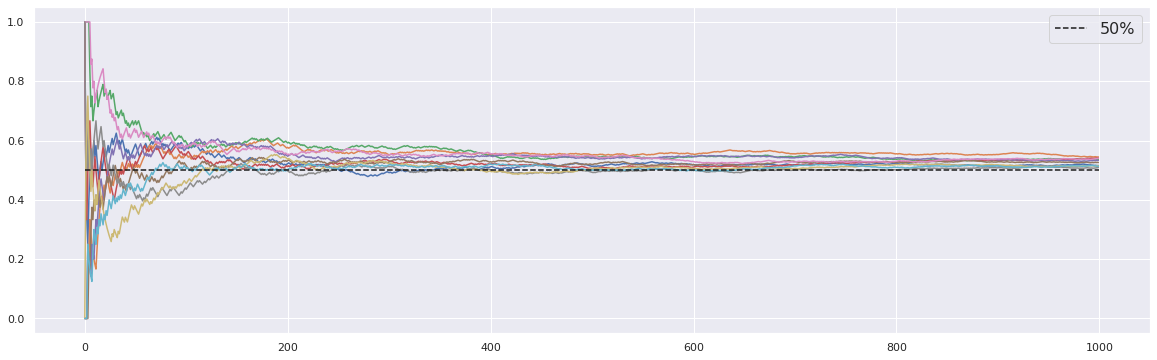

In [ ]:
jurors_proba = 0.53
num_jurors = 10; num_trals = 1000
num_decisions=(np.random.rand(num_trals, num_jurors)<jurors_proba)*1
total_trials = np.arange(1, num_trals+1).reshape(-1, 1)
cum_right_ratio=np.cumsum(num_decisions, axis=0)/total_trials
plt.figure(figsize=(20,6)); plt.plot(cum_right_ratio)
plt.plot([0, num_trals], [0.5, 0.5], 'k--', label='50%')
plt.legend()

## **2. Bagging(Bootstrapping aggregation) 알고리즘**

Random Forest is one of the most popular and most powerful machine learning algorithms. It is a type of ensemble machine learning algorithm called Bootstrap Aggregation or bagging.
- The bootstrap method for estimating statistical quantities from samples.
- The Bootstrap Aggregation algorithm for creating **multiple different models from a single training dataset.**
- The Random Forest algorithm that makes **a small tweak to Bagging** and results in a very powerful classifier.

<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fb4wG8O%2FbtqyfYW98AS%2FYZBtUJy3jZLyuik1R0aGNk%2Fimg.png'>

- **Depth가 '1'인 의사결정 tree(Stump) 500개로 Bagging 예측** 
     * bootstapping (sample의 80%를 bootstrapping)

In [ ]:
from sklearn import ensemble 
stump= DecisionTreeClassifier(max_depth=1, random_state=1357)
bag = ensemble.BaggingClassifier(stump, n_estimators = 500, max_samples =0.8)
y_predict = bag.fit(X_train, y_train).predict(X_test)
accuracy_score(y_test, y_predict)
print(classification_report(y_test, y_predict))

0.868421052631579

              precision    recall  f1-score   support

           0       0.94      0.69      0.79        42
           1       0.84      0.97      0.90        72

    accuracy                           0.87       114
   macro avg       0.89      0.83      0.85       114
weighted avg       0.88      0.87      0.86       114



- **의사결정 tree 30개로 Bagging 예측** 
     * bootstapping (sample의 80%를 bootstrapping)

In [ ]:
from sklearn import ensemble 
np.random.seed(1357) 
dt = DecisionTreeClassifier(random_state=11)
bag = ensemble.BaggingClassifier(dt, n_estimators = 30, max_samples =0.8)
y_predict = bag.fit(X_train, y_train).predict(X_test)
accuracy_score(y_test, y_predict)
print(classification_report(y_test, y_predict))

0.9649122807017544

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        42
           1       0.95      1.00      0.97        72

    accuracy                           0.96       114
   macro avg       0.97      0.95      0.96       114
weighted avg       0.97      0.96      0.96       114



In [ ]:
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_val_predict

cross_val_score(dt, X, y, cv=5, scoring='f1_macro')
print('\n')

cross_val_score(dt, X, y, cv=5, scoring='recall')
print('\n')

scoring = ['precision_macro', 'recall_macro']
cross_validate(dt, X, y, scoring=scoring)

print('\n')
cross_val_predict(dt, X, y, cv=3)

array([0.90821256, 0.89777452, 0.92382225, 0.9329806 , 0.89000649])

array([0.90140845, 0.91549296, 0.95833333, 0.97222222, 0.85915493])

{'fit_time': array([0.05271244, 0.02596641, 0.07016063, 0.01390195, 0.02036524]),
 'score_time': array([0.02785945, 0.01370931, 0.00580812, 0.0063498 , 0.00767565]),
 'test_precision_macro': array([0.90314386, 0.8961039 , 0.92871622, 0.94102564, 0.88412698]),
 'test_recall_macro': array([0.9158205 , 0.89960694, 0.91964286, 0.9265873 , 0.90576794])}

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,

## **3. Random Forest 알고리즘**

As such, even with Bagging, the decision trees can have a lot of structural similarities and in turn result in high correlation in their predictions. Combining predictions from multiple models in ensembles works better if the predictions from the submodels are uncorrelated or at best weakly correlated.
Random forest **changes the algorithm for the way that the sub-trees are learned so that the resulting predictions from all of the subtrees have less correlation.**

### **3.1. Random forest 작동 원리**
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

- 배깅 모델의 한 종류로 노드별로 데이터의 개수와 입력 변수를 다르게 적용
고차원 변수에 적합(이미지 데이터)

- 하이퍼파라미터는 **max_features**와 **bootstrap_features** 
    * **첫 단계로** 훈련데이터에서 중복을 허용하여 훈련데이터와 같은 크기로 부트스트래핑 추출하여 사용하고 추출되지 않은 표본은 검증데이터로 사용
    * **두 번째 단계는** 각 노드에서 입력 변수 개수 적은 변수 (SQRT(입력변수 개수))를 비복원 무작위 추출하여 의사결정트리를 생성(bootstrap_features)
    * 처음과 두 번째 단계를 계속 반복하여 만드는 형태가 마치 숲을 만드는 것과 유사
    * 처음과 두번째의 무작위성(randomness)는 예측오류를 디커플링(decoupling)하여 모형의 과적합을 방지해 줌
- 계층 수(depth)가 적은 모델(shallow trees, weak learners)을 여러 개 만들어 다수결이나 평균값으로 예측 
    * 예측의 평균을 취하면 일부 오류가 상쇄될 가능성이 커짐
    * 랜덤 포레스트는 **다양한 트리를 결합하여 분산을 줄이고 편향을 약간 증가시킴**
    * 실제로 분산 감소가 더 중요하여 전반적으로 더 나은 모델을 생성

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(5, 20, 10)]
min_samples_split = np.arange(2, 30, 2)
min_samples_leaf = np.arange(2, 50, 2)
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score
np.random.seed(4321)
rf = ensemble.RandomForestClassifier(random_state=11)
rf_random = RandomizedSearchCV(rf, random_grid, cv=kf, scoring = 'recall')
y_predict = rf_random.fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, y_predict))
y_proba = rf_random.predict_proba(X_test)
print(f'정확도(accuracy): {accuracy_score(y_test, y_predict)}')
print(f'AUROC: {roc_auc_score(y_test, y_proba[:, 1])}')
print(f'AP: {average_precision_score(y_test, y_proba[:, 1])}')

              precision    recall  f1-score   support

           0       1.00      0.86      0.92        42
           1       0.92      1.00      0.96        72

    accuracy                           0.95       114
   macro avg       0.96      0.93      0.94       114
weighted avg       0.95      0.95      0.95       114

정확도(accuracy): 0.9473684210526315
AUROC: 0.9735449735449735
AP: 0.9747058887799015


### **3.2 OOB Error(Out of Bag Error) with bootstrapping**

In [ ]:
print(f'- Bootstrapping 10,000회에도 한번도 선택되지 못할 확률: {(1-1/10000)**10000}')
print(f'- 자연로그 밑의 오일러 지수의 역수: {1/np.e}')

- Bootstrapping 10,000회에도 한번도 선택되지 못할 확률: 0.36786104643297046
- 자연로그 밑의 오일러 지수의 역수: 0.36787944117144233


In [ ]:
n = 100000
trials = 100000
print(f'1 회 비복원추출시 뽑힐 확률은 {1/n}')
print(f'1 회 비복원추출시 안 뽑힐 확률은 {(1-1/n)}')
print(f'{trials}번 비복원 추출시 계속 안 뽑힐 확률은 {(1-1/n)**trials}')

import math
1/math.e

1 회 비복원추출시 뽑힐 확률은 1e-05
1 회 비복원추출시 안 뽑힐 확률은 0.99999
100000번 비복원 추출시 계속 안 뽑힐 확률은 0.3678776017682465


0.36787944117144233

In [ ]:
rf = ensemble.RandomForestClassifier(n_estimators=300, oob_score=True,
                                     max_features='sqrt', random_state=11)
rf.fit(X_train, y_train)
y_predict = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_predict)
print(f'Mean accuracy score: {accuracy:.3}')
print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')

RandomForestClassifier(max_features='sqrt', n_estimators=300, oob_score=True,
                       random_state=11)

Mean accuracy score: 0.965
Out-of-bag score estimate: 0.952


### **3.3. 랜덤포레스트의 무작위성(Non-paremetric model)**
- 빈 리스트를 만들고 랜덤시드를 서로 다르게 50회 반복하여 훈련과 검증데이터를 만들어 종속변수의 범주 유형 비율의 차이를 그림으로 확인한다. 
- 랜덤 시드가 달라지면 훈련과 검증데이터의 범주 유형 비율이 달라진다는 것을 알 수 있다.
- Non-parametric 통계모델

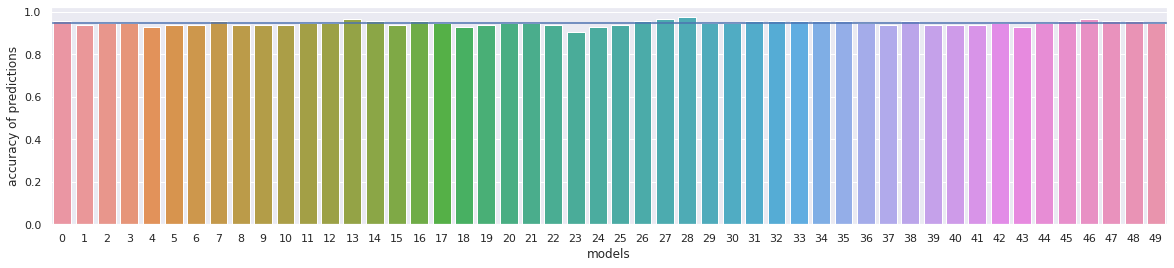

In [ ]:
acc_list = []

for i in np.random.choice(2500, 50, replace=False) :
    clf = ensemble.RandomForestClassifier(n_estimators = 5, random_state = i) 
    preds =  clf.fit(X_train, y_train).predict(X_test)  
    acc = round(accuracy_score(y_true = y_test, y_pred = preds), 3)
    acc_list.append(acc)

data = (pd.Series(acc_list).reset_index().
        rename(columns={'index': 'models', 0: 'accuracy of predictions'}))

fig, ax = plt.subplots()
fig.set_size_inches(20, 4)
ax = sns.barplot(x='models', y='accuracy of predictions', data=data)
plt.axhline(data['accuracy of predictions'].mean())

특성변수 영향도(partial dependence)

- 사이킷런의 feature importance와 permutation importance는 예측에 영향을 미치는 상대적 중요도를 나타낸다. 
- pdp는 예측 확률에 어떻게 영향을 미치는지를 보여준다. 
- 전체 입력변수의 상대적인 중요도가 아닌 개별 변수의 민감도

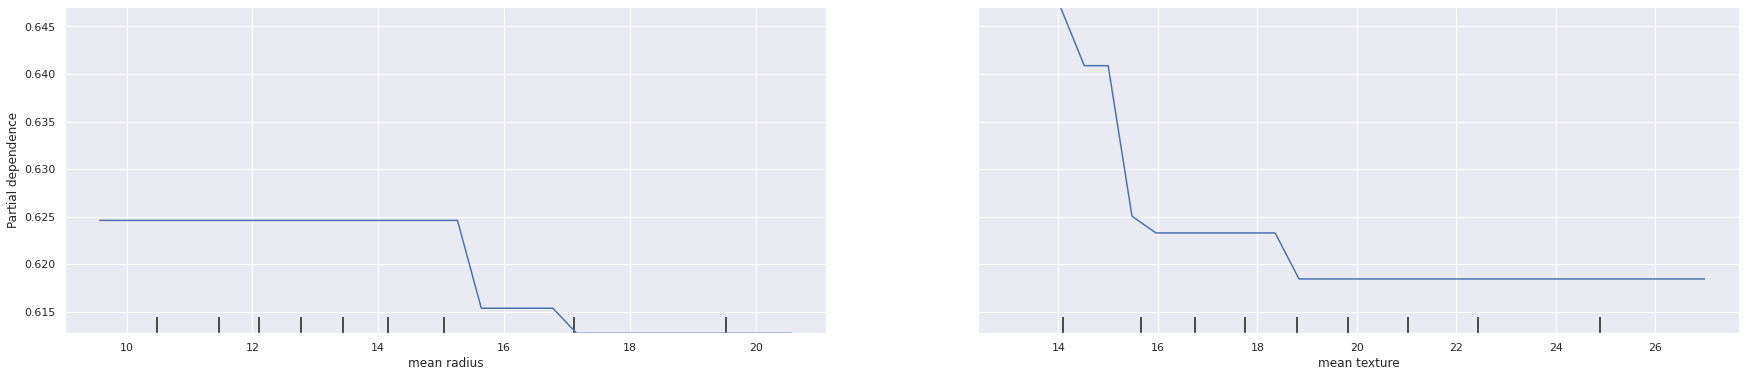

In [ ]:
from sklearn.inspection import plot_partial_dependence
plt.rcParams['figure.figsize'] = (30,6)
features = ['mean radius', 'mean texture']
plot_partial_dependence(clf, X_train, features, n_jobs=3, grid_resolution=30)
fig = plt.gcf(); fig.subplots_adjust(hspace=2)

## **4. Extremely Randomized Trees**
In extremely randomized trees (see ExtraTreesClassifier and ExtraTreesRegressor classes), randomness goes one step further in the way splits are computed. As in random forests, a random subset of candidate features is used, but instead of looking for the most discriminative thresholds, thresholds are drawn at random for each candidate feature and the best of these **randomly-generated thresholds is picked as the splitting rule**. This usually allows **to reduce the variance** of the model a bit more, **at the expense of a slightly greater increase in bias**:

In [ ]:
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns= data.feature_names)
y = pd.Series(data.target)

In [ ]:
extree = ensemble.ExtraTreesClassifier(random_state=0)
cross_val_score(clf, X, y, cv=10)
y_predict = extree.fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, y_predict))
y_proba = rf_random.predict_proba(X_test)
print(f'정확도(accuracy): {accuracy_score(y_test, y_predict)}')
print(f'AUROC: {roc_auc_score(y_test, y_proba[:, 1])}')
print(f'AP: {average_precision_score(y_test, y_proba[:, 1])}')

array([0.92982456, 0.87719298, 0.92982456, 0.96491228, 1.        ,
       0.98245614, 0.89473684, 0.96491228, 0.98245614, 0.96428571])

              precision    recall  f1-score   support

           0       1.00      0.88      0.94        42
           1       0.94      1.00      0.97        72

    accuracy                           0.96       114
   macro avg       0.97      0.94      0.95       114
weighted avg       0.96      0.96      0.96       114

정확도(accuracy): 0.956140350877193
AUROC: 0.9735449735449735
AP: 0.9747058887799015


## **6. Random Forest Regression**

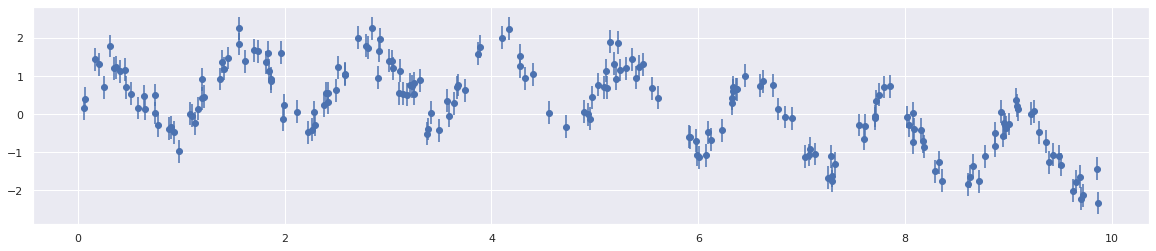

In [ ]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200)
def data_generator(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))
    return slow_oscillation + fast_oscillation + noise
y = data_generator(x)
plt.figure(figsize=(20, 4))
plt.errorbar(x, y, 0.3, fmt='o');

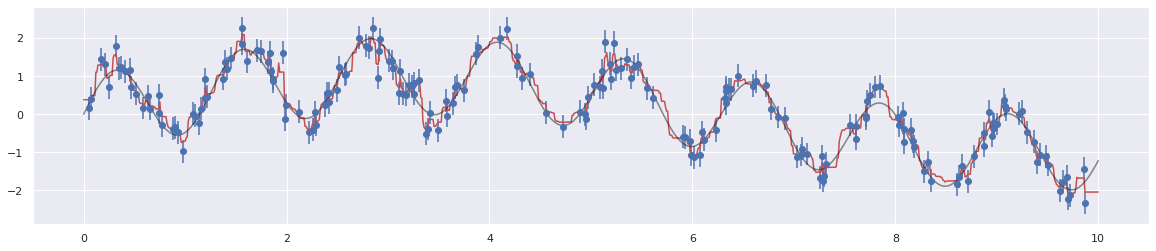

In [ ]:
forest = ensemble.RandomForestRegressor(200)
forest.fit(x[:, None], y)
xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = data_generator(xfit, sigma=0)
plt.figure(figsize=(20, 4))
plt.errorbar(x, y, 0.3, fmt='o', alpha=1)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

## **7. VotingClassifier**
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html

<img src='https://i2.wp.com/thecleverprogrammer.com/wp-content/uploads/2020/07/un-111.png' width=800>

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

estimators=[('lgr', LogisticRegression(solver='saga', class_weight='balanced')),
            ('rf',  ensemble.RandomForestClassifier(class_weight='balanced')),
            ('gnb', GaussianNB())]
            
eclf = ensemble.VotingClassifier(estimators, voting='soft')

params = {
    'lgr__C': [0.01, 0.1, 1, 10], 'lgr__penalty': ['l1', 'l2'], 
    'rf__n_estimators': [200], 'rf__max_features': ['auto', 'sqrt', 'log2'],
    'rf__max_depth' : [3, 4, 5, 6, 7, 8], 'rf__criterion' :['gini', 'entropy'],
    'gnb__var_smoothing': [1e-9, 1e-8,1e-7, 1e-6, 1e-5]
}

In [ ]:
kf = KFold(n_splits=5)
grid = RandomizedSearchCV(eclf, params, cv = kf,  verbose = 1, n_iter = 5,
                          scoring = 'f1_macro')           
      
y_predict = grid.fit(X_train, y_train).predict(X_test)
y_proba = grid.fit(X_train, y_train).predict_proba(X_test)
print(f'AUROC: {roc_auc_score(y_test, y_proba[:, 1])}')
print(f'AP: {average_precision_score(y_test, y_proba[:, 1])}')
print(classification_report(y_test, y_predict))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
AUROC: 0.9877645502645502
AP: 0.9926300531288839
              precision    recall  f1-score   support

           0       0.97      0.86      0.91        42
           1       0.92      0.99      0.95        72

    accuracy                           0.94       114
   macro avg       0.95      0.92      0.93       114
weighted avg       0.94      0.94      0.94       114



## **8. Boosting 모델**
Boosting is a general ensemble method that **creates a strong classifier from a number of weak classifiers.** This is done by building a model from the training data, then creating a second model that attempts to correct the errors from the first model. Models are added until the training set is predicted perfectly or a maximum number of models are added.
<img src= 'https://upload.wikimedia.org/wikipedia/commons/thumb/a/ae/Darwin%27s_finches_by_Gould.jpg/375px-Darwin%27s_finches_by_Gould.jpg'>

## **9. Adaboosting**
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

- 후행 분류기가 선행 분류기를 차례로 학습
    * 여러 약한 분류기가 선행 분류기가 잘못 분류한 자료에 가중치를 부여하여 후속 분류기가 계속 학습
    * To reduces bias of the base learners
    * Boosting is **a gradient descent on function space.**

<img src='https://jinsu-l.github.io/assets/post_images/image-20191217222322387.png' width=800>


## **10. Gradient Boosting**
- It relies on the intuition that the best possible next model, when combined with previous models, minimizes the overall prediction error. 
- GB builds an **additive model** in a **forward stage-wise fashion**
- The key idea is to set the target outcomes for this next model in order to minimize the error. 
- Gradient Boosting can be used for both Classification and Regression

<img src='https://miro.medium.com/max/1120/1*85QHtH-49U7ozPpmA5cAaw.png'>

In [ ]:
from sklearn import tree
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5;  y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)
tree_reg1 =tree.DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)
y2 = y - tree_reg1.predict(X)
tree_reg2 = tree.DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = tree.DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

X_new = np.array([[0.8]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred

DecisionTreeRegressor(max_depth=2, random_state=42)

DecisionTreeRegressor(max_depth=2, random_state=42)

DecisionTreeRegressor(max_depth=2, random_state=42)

array([0.75026781])

In [ ]:
def plot_predictions(regressors, X, y, axes, label=None, 
                     style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

<Figure size 1440x720 with 0 Axes>

Text(0, 0.5, '$y$')

Text(0.5, 1.0, 'Residuals and tree predictions')

Text(0, 0.5, '$y$')

Text(0.5, 1.0, 'Ensemble predictions')

Text(0, 0.5, '$y - h_1(x_1)$')

Text(0, 0.5, '$y$')

Text(0, 0.5, '$y - h_1(x_1) - h_2(x_1)$')

Text(0.5, 0, '$x_1$')

Text(0.5, 0, '$x_1$')

Text(0, 0.5, '$y$')

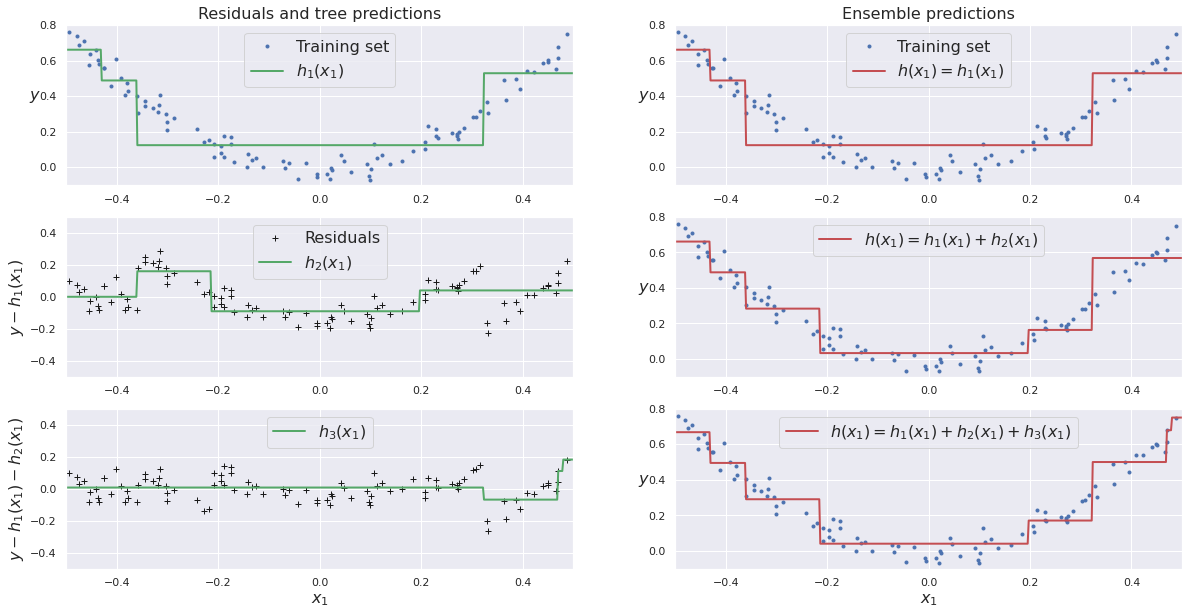

In [ ]:
plt.figure(figsize=(20, 10))
plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0); plt.title("Residuals and tree predictions", fontsize=16)
plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0); plt.title("Ensemble predictions", fontsize=16)
plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)
plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16); plt.xlabel("$x_1$", fontsize=16)
plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16); plt.ylabel("$y$", fontsize=16, rotation=0)
plt.show()

### **주요 Hyperparameters**

**1. learning rate**

**2. estimator개수**

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

Text(0.5, 1.0, 'learning_rate=1.0, n_estimators=3')

Text(0.5, 0, '$x_1$')

Text(0, 0.5, '$y$')

Text(0.5, 1.0, 'learning_rate=0.1, n_estimators=200')

Text(0.5, 0, '$x_1$')

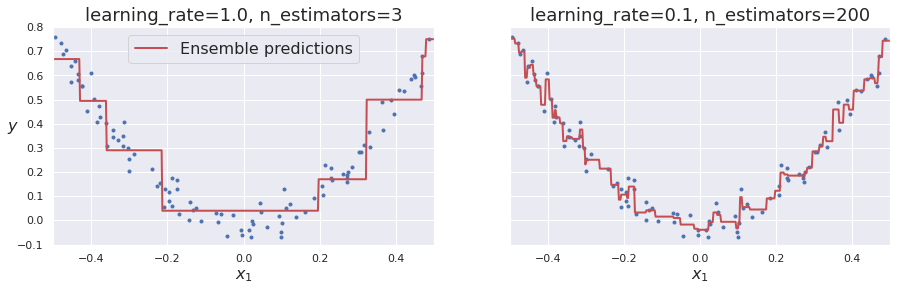

In [ ]:
gbrt = ensemble.GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)
gbrt_slow = ensemble.GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

fix, axes = plt.subplots(ncols=2, figsize=(15,4), sharey=True)
plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title(f'learning_rate={gbrt.learning_rate}, n_estimators={gbrt.n_estimators}',fontsize=18)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title(f'learning_rate={gbrt_slow.learning_rate}, n_estimators={gbrt_slow.n_estimators}',fontsize=18)
plt.xlabel("$x_1$", fontsize=16)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=20,
                          random_state=42)

GradientBoostingRegressor(max_depth=2, n_estimators=20, random_state=42)

Text(0.5, 1.0, 'learning_rate=1.0, n_estimators=20')

Text(0.5, 0, '$x_1$')

Text(0, 0.5, '$y$')

Text(0.5, 1.0, 'learning_rate=0.1, n_estimators=20')

Text(0.5, 0, '$x_1$')

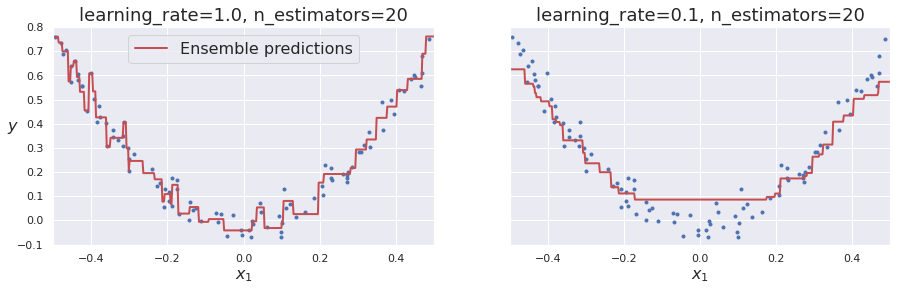

In [ ]:
gbrt = ensemble.GradientBoostingRegressor(max_depth=2, n_estimators=20, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)
gbrt_slow = ensemble.GradientBoostingRegressor(max_depth=2, n_estimators=20, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

fix, axes = plt.subplots(ncols=2, figsize=(15,4), sharey=True)
plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title(f'learning_rate={gbrt.learning_rate}, n_estimators={gbrt.n_estimators}',fontsize=18)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title(f'learning_rate={gbrt_slow.learning_rate}, n_estimators={gbrt_slow.n_estimators}',fontsize=18)
plt.xlabel("$x_1$", fontsize=16)

**3. 조기 종료(Early stopping)**
- 1,000개의 분류기를 모두 실행하지 않고 5번에 걸친 학습 결과에도 로그 손실이 개선되지 않으면 학습을 중단

GradientBoostingClassifier(learning_rate=0.05, max_depth=1, n_estimators=500,
                           random_state=42, warm_start=True)

<Figure size 720x432 with 0 Axes>

Text(166, 0.1854477201288322, 'Minimum')

Text(0.5, 0, 'Number of trees')

Text(0, 0.5, 'Error')

Text(0.5, 1.0, 'Validation log_loss error')

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


최소 로그손실 값은: 0.1818114903223845
의사결정트리 개수: 166
learning_rate 0.05


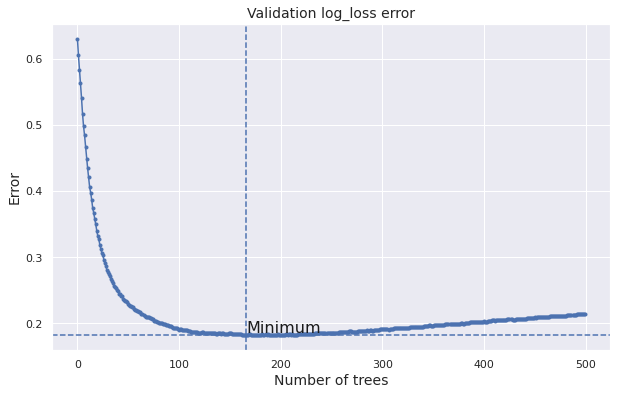

In [ ]:
from sklearn import metrics

gbrt = ensemble.GradientBoostingClassifier(max_depth=1, n_estimators=500, warm_start=True,
                                  learning_rate=0.05, random_state=42)
gbrt.fit(X_train, y_train)
errors = [metrics.log_loss(y_test, y_proba)
          for y_proba in gbrt.staged_predict_proba(X_test)]

plt.figure(figsize=(10, 6)); plt.plot(errors, "b.-")
plt.axhline(y= np.min(errors), linestyle='--'); plt.axvline(x= np.argmin(errors), linestyle='--')
plt.text(np.argmin(errors), np.min(errors)*1.02, "Minimum", color='k', fontsize=16)
plt.xlabel("Number of trees",fontsize=14); plt.ylabel("Error", fontsize=14); 
plt.title("Validation log_loss error", fontsize=14)

print('최소 로그손실 값은:', np.min(errors))
print('의사결정트리 개수:',np.argmin(errors))
print('learning_rate', gbrt.get_params()['learning_rate'])

## **11. Stacking and Blending model**
- Stacked generalization is a method for **combining estimators to reduce their biases.**
    * Layered structure, Not winner takes all, diversity
- More precisely, **the predictions of each individual estimator are stacked together and used as input to a final estimator** to compute the prediction.
    * Predictions from the models in the previous layer are used as input to the sequential layer 
- This **final estimator is trained through cross-validation**.
    * New models will train on the these inputs and producr a final result

<img src='https://miro.medium.com/max/1400/1*-4VerxoDZVYb9MxJ1Eee7w.png'>

**Understanding of Stacking and Blending with cross validation**
- 4개의 모델로 stacking한 내부 작동방식 이해

In [ ]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier 
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.preprocessing import StandardScaler 
from sklearn.pipeline import make_pipeline 

**Step 1**
- Stacking 대상 모델을 불러오기 
- Final estimator와 stacking 모델을 belnding할 StackingClassifier API 호출
- Iris 데이터 불러오기

In [ ]:
from sklearn.datasets import load_wine
data  = load_wine()
df = pd.DataFrame(data.data, columns = data['feature_names'])
df['target'] = data.target
df[100::2].loc[df['target'] == 2, 'target']  = 0
df[101::2].loc[df['target'] == 2, 'target']  = 1
X = df[data['feature_names']]
y = df['target']
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, 
                                                  stratify= y, random_state=11)
X_train.shape, X_test.shape

((142, 13), (36, 13))

**Step 2**
- 4개의 Base models 정의 및 객체화
- Base learners를 튜블(tuple)자료 형태를 원소로 하여 리스트[(‘str’, API)]로 구성

In [ ]:
from sklearn import ensemble

In [ ]:
clf1 = ensemble.RandomForestClassifier(n_estimators=10, random_state=5)
clf2 = make_pipeline(StandardScaler(), SVC(random_state=5))
clf3 = GaussianNB()
clf4 = make_pipeline(StandardScaler(), KNeighborsClassifier())

**Step 3**
- Stacking classifiers and meta model 정의
- Final estimator를 로지스틱회귀로 하는  stacking 모델(meta model)을 belnding
- 4개의 Base models 예측 결과를 prediction 결과값을 입력변수로 받아 meta leaner(로지스틱회귀)가 3 겹 교차검증 학습

In [ ]:
estimators = [
    ('rf', RandomForestClassifier(n_estimators=10, random_state=5)),
    ('svr', make_pipeline(StandardScaler(),SVC(random_state=5))),
    ('gnb', GaussianNB(),
    ('knn', make_pipeline(StandardScaler(),KNeighborsClassifier())))
]

meta = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression()) 

**Step 4**
- Base models의 prediction 결과값을 입력변수로 받아 meta leaner(로지스틱회귀)가 학습

In [ ]:
from sklearn import model_selection
list = zip([clf1, clf2, clf3, clf4, meta], 
           ['RandomForest', 'SVC', 'GaussianNB', 'KNN', 'Stacking'])

for classifier, name in list:
    scores = model_selection.cross_val_score(classifier, X_train, y_train, cv=3)
    print(f'모델 {name}의 정확도 : {scores.mean()}\n')

y_predict = meta.fit(X_train, y_train).predict(X_test)
print(f'{name}모델의 classification report\n')

print(classification_report(y_test, y_predict))

모델 RandomForest의 정확도 : 0.7956560283687942

모델 SVC의 정확도 : 0.8169326241134751

모델 GaussianNB의 정확도 : 0.8312647754137116

모델 KNN의 정확도 : 0.7609338061465721

모델 Stacking의 정확도 : 0.8028959810874704

Stacking모델의 classification report

              precision    recall  f1-score   support

           0       0.93      0.76      0.84        17
           1       0.82      0.95      0.88        19

    accuracy                           0.86        36
   macro avg       0.87      0.86      0.86        36
weighted avg       0.87      0.86      0.86        36



## Classifier comparison
https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

<img src = 'https://scikit-learn.org/stable/_images/sphx_glr_plot_classifier_comparison_001.png'>

## **12. CatBoost Model**
- https://colab.research.google.com/github/catboost/tutorials/blob/master/python_tutorial.ipynb#scrollTo=N1oOE4JRJuoB

Tree based models have a strong tendency to overestimate the importance of continuous numerical or high carinality categorical features.

In [ ]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mushroom', as_frame=True, return_X_y=True)
X = pd.get_dummies(X)
seed= 11
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, 
                                                  random_state=seed)

In [ ]:
! pip install catboost
from catboost import CatBoostClassifier

In [ ]:
params = {'loss_function':'Logloss', 'eval_metric':'Accuracy', 
          'verbose': 200, 'random_seed': seed}
          
cbc_1 = CatBoostClassifier(**params)

cbc_1.fit(X_train, y_train, 
          eval_set=(X_test, y_test), 
          plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.050313
0:	learn: 0.9867672	test: 0.9889231	best: 0.9889231 (0)	total: 56.1ms	remaining: 56.1s
200:	learn: 1.0000000	test: 0.9987692	best: 0.9987692 (2)	total: 1.4s	remaining: 5.55s
400:	learn: 1.0000000	test: 0.9987692	best: 0.9987692 (2)	total: 2.14s	remaining: 3.2s
600:	learn: 1.0000000	test: 0.9987692	best: 0.9987692 (2)	total: 3.04s	remaining: 2.02s
800:	learn: 1.0000000	test: 0.9987692	best: 0.9987692 (2)	total: 3.71s	remaining: 921ms
999:	learn: 1.0000000	test: 0.9987692	best: 0.9987692 (2)	total: 5.09s	remaining: 0us

bestTest = 0.9987692308
bestIteration = 2

Shrink model to first 3 iterations.


# End